In [2]:
import pennylane as qml
import numpy as np
import matplotlib.pyplot as plt

In [53]:
from tqdm import tqdm

In [3]:
import jax
import jax.numpy as jnp

jax.config.update("jax_enable_x64", True)

In [4]:
import optax

In [5]:
from QCBM import QCBM, KLDivergence, MMD

## Mixture of Gaussains

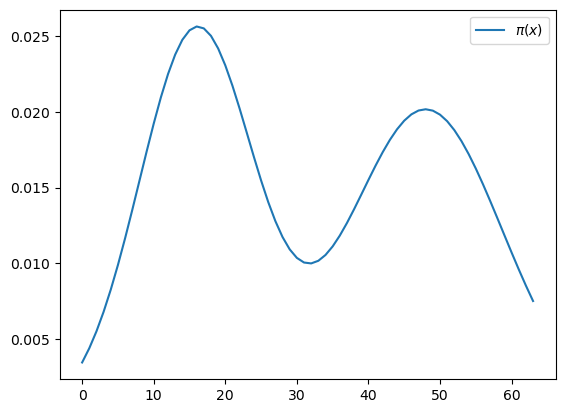

In [6]:
def mixture_gaussian_pdf(x, mus, sigmas):
    mus, sigmas = np.array(mus), np.array(sigmas)
    vars = sigmas**2
    values = [
        (1 / np.sqrt(2 * np.pi * v)) * np.exp(-((x - m) ** 2) / (2 * v)) for m, v in zip(mus, vars)
    ]
    values = np.sum([val / sum(val) for val in values], axis=0)
    return values / np.sum(values)


n_qubits = 6
x_max = 2**n_qubits
x_input = np.arange(x_max)
mus = [(1 / 4) * x_max, (3 / 4) * x_max]
sigmas = [x_max / 8, x_max/6]
data = mixture_gaussian_pdf(x_input, mus, sigmas)

plt.plot(data, label=r"$\pi(x)$")
plt.legend()
plt.show()

## Arbritray U Rotation

In [80]:
dev = qml.device("default.qubit", wires=n_qubits)

weights = np.random.rand(n_qubits,3)


@qml.qnode(dev)
def circuit(weights):
    for i in range(n_qubits):
        qml.U3(
            theta = weights[i][0], 
            phi = weights[i][1], 
            delta = weights[i][2], 
            wires = i, id=None
        )
    return qml.probs()


jit_circuit = jax.jit(circuit)

# qml.draw_mpl(circuit, level="device")(weights)
# plt.show()
# plt.savefig("Ansatz/U3_1Layer")

Step: 0 Loss: 0.2542 KL-div: 5.7287
Step: 10 Loss: 0.0059 KL-div: 0.3397
Step: 20 Loss: 0.0149 KL-div: 0.2683
Step: 30 Loss: 0.0042 KL-div: 0.1531
Step: 40 Loss: 0.0023 KL-div: 0.1021
Step: 50 Loss: 0.0016 KL-div: 0.0772
Step: 60 Loss: 0.0011 KL-div: 0.0686
Step: 70 Loss: 0.0011 KL-div: 0.0665
Step: 80 Loss: 0.0010 KL-div: 0.0668
Step: 90 Loss: 0.0010 KL-div: 0.0660


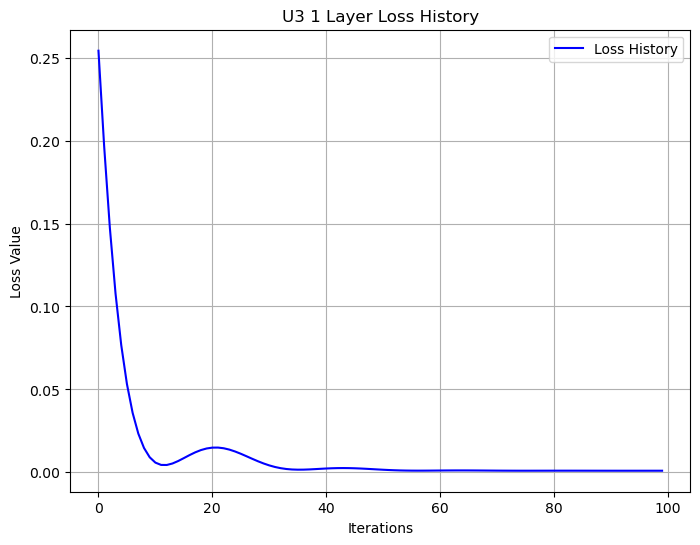

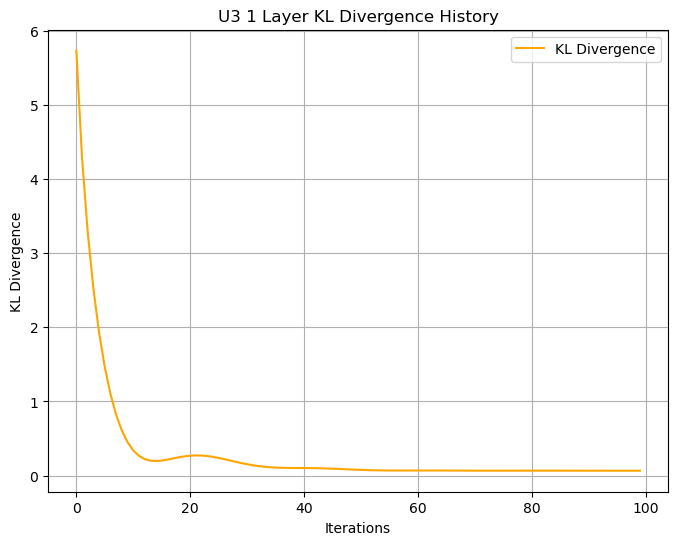

In [81]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

# save figures for history and kl divergence

# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(history, label="Loss History", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("U3 1 Layer Loss History")
plt.legend()
plt.grid(True)
plt.savefig("Results/U3/U3_1Layer_Loss_History.png")
# plt.show()

# Plot the KL divergence history
plt.figure(figsize=(8, 6))
plt.plot(divs, label="KL Divergence", color='orange')
plt.xlabel("Iterations")
plt.ylabel("KL Divergence")
plt.title("U3 1 Layer KL Divergence History")
plt.legend()
plt.grid(True)
plt.savefig("Results/U3/U3_1Layer_KL_Div_History.png")
# plt.show()
        

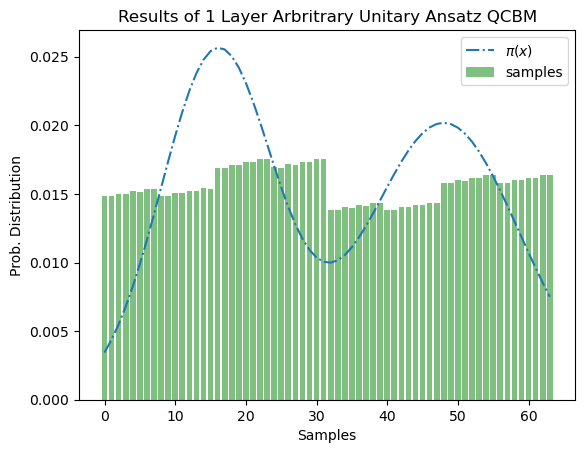

In [82]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.title('Results of 1 Layer Arbritrary Unitary Ansatz QCBM')

plt.legend()

plt.savefig("Results/U3/U3_1Layers")
plt.show()

#### 2 Layers

In [83]:
dev = qml.device("default.qubit", wires=n_qubits)
n_layers = 2

weights = []
for n in range(n_layers):
    weights.append(np.random.rand(n_qubits,3))

@qml.qnode(dev)
def circuit(weights):
    for n in range(n_layers):
        for i in range(n_qubits):
            qml.U3(
                theta = weights[n][i][0], 
                phi = weights[n][i][1], 
                delta = weights[n][i][2], 
                wires = i, id=None
            )
    return qml.probs()


jit_circuit = jax.jit(circuit)

# qml.draw_mpl(circuit, level="device")(weights)
# plt.show()
# plt.savefig("Ansatz/U3_2Layer")

Step: 0 Loss: 0.0010 KL-div: 0.0658
Step: 10 Loss: 0.0015 KL-div: 0.0903
Step: 20 Loss: 0.0011 KL-div: 0.0710
Step: 30 Loss: 0.0010 KL-div: 0.0684
Step: 40 Loss: 0.0010 KL-div: 0.0665
Step: 50 Loss: 0.0010 KL-div: 0.0665
Step: 60 Loss: 0.0010 KL-div: 0.0658
Step: 70 Loss: 0.0010 KL-div: 0.0658
Step: 80 Loss: 0.0010 KL-div: 0.0659
Step: 90 Loss: 0.0010 KL-div: 0.0657


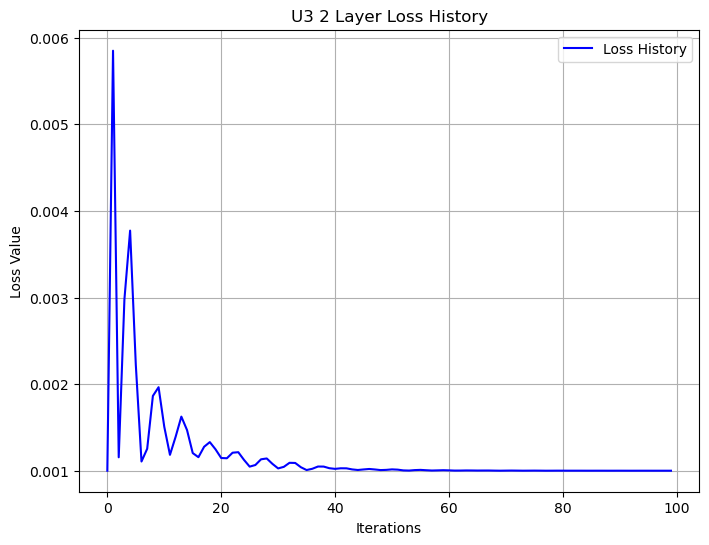

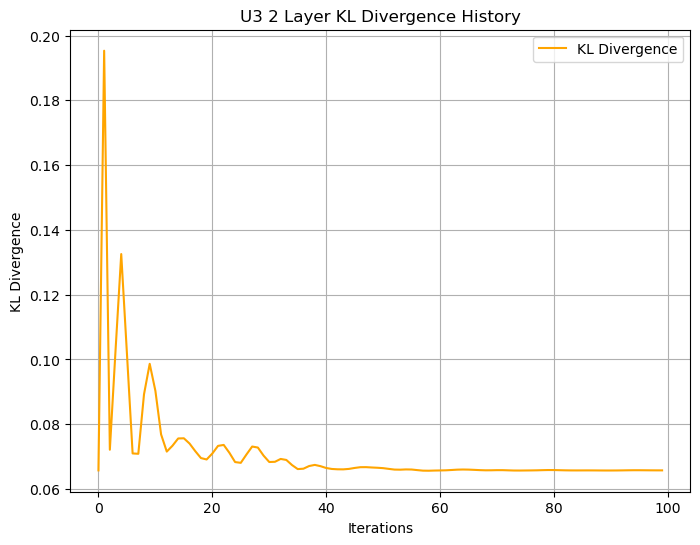

In [85]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(history, label="Loss History", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("U3 2 Layer Loss History")
plt.legend()
plt.grid(True)
plt.savefig("Results/U3/U3_2Layer_Loss_History.png")
plt.show()

# Plot the KL divergence history
plt.figure(figsize=(8, 6))
plt.plot(divs, label="KL Divergence", color='orange')
plt.xlabel("Iterations")
plt.ylabel("KL Divergence")
plt.title("U3 2 Layer KL Divergence History")
plt.legend()
plt.grid(True)
plt.savefig("Results/U3/U3_2Layer_KL_Div_History.png")
plt.show()

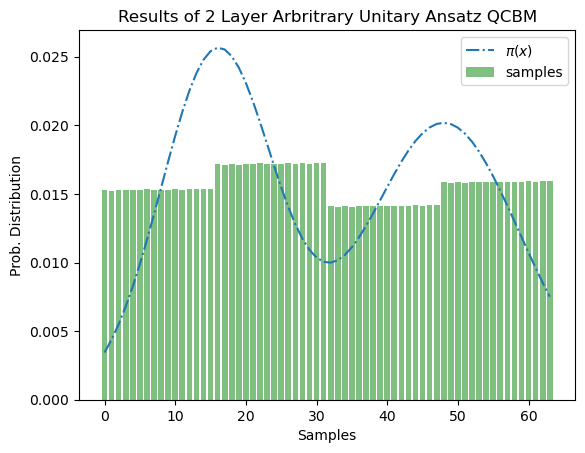

In [86]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.title('Results of 2 Layer Arbritrary Unitary Ansatz QCBM')

plt.legend()

plt.savefig("Results/U3/U3_2Layers")
plt.show()

## 10 Layers

In [87]:
dev = qml.device("default.qubit", wires=n_qubits)
n_layers = 10

weights = []
for n in range(n_layers):
    weights.append(np.random.rand(n_qubits,3))

@qml.qnode(dev)
def circuit(weights):
    for n in range(n_layers):
        for i in range(n_qubits):
            qml.U3(
                theta = weights[n][i][0], 
                phi = weights[n][i][1], 
                delta = weights[n][i][2], 
                wires = i, id=None
            )
    return qml.probs()


jit_circuit = jax.jit(circuit)

# qml.draw_mpl(circuit, level="device")(weights)
# plt.savefig("Ansatz/U3_10Layer")
# plt.show()

Step: 0 Loss: 0.0010 KL-div: 0.0659
Step: 10 Loss: 0.0031 KL-div: 0.1868
Step: 20 Loss: 0.0043 KL-div: 0.2779
Step: 30 Loss: 0.0023 KL-div: 0.1517
Step: 40 Loss: 0.0013 KL-div: 0.0883
Step: 50 Loss: 0.0012 KL-div: 0.0759
Step: 60 Loss: 0.0011 KL-div: 0.0693
Step: 70 Loss: 0.0010 KL-div: 0.0666
Step: 80 Loss: 0.0010 KL-div: 0.0660
Step: 90 Loss: 0.0010 KL-div: 0.0659


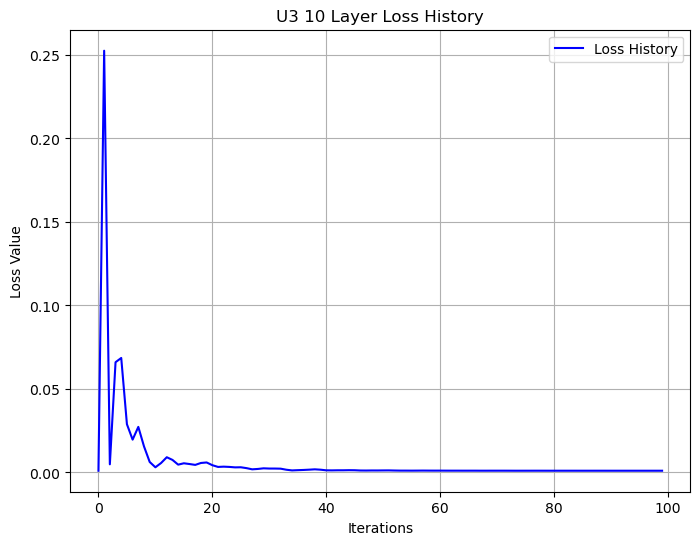

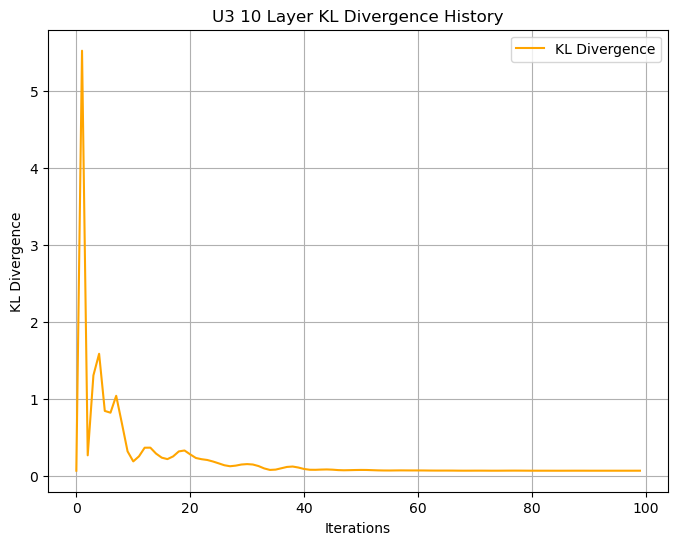

In [94]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
    # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(history, label="Loss History", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("U3 10 Layer Loss History")
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig("Results/U3/U3_10Layer_Loss_History.png")
plt.show()

# Plot the KL divergence history
plt.figure(figsize=(8, 6))
plt.plot(divs, label="KL Divergence", color='orange')
plt.xlabel("Iterations")
plt.ylabel("KL Divergence")
plt.title("U3 10 Layer KL Divergence History")
# plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig("Results/U3/U3_10Layer_KL_Div_History.png")
plt.show()

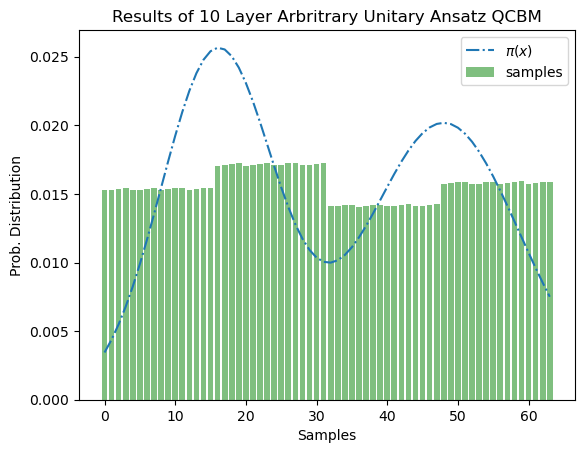

In [89]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.title('Results of 10 Layer Arbritrary Unitary Ansatz QCBM')

plt.legend()

plt.savefig("Results/U3/U3_10Layers")
plt.show()

## RX RY RZ Rotation

In [68]:
dev = qml.device("default.qubit", wires=n_qubits)

weights = np.random.rand(n_qubits,3)


@qml.qnode(dev)
def circuit(weights):
    for i in range(n_qubits):
        qml.Rot(
            phi = weights[i][0], 
            theta = weights[i][1], 
            omega = weights[i][2], 
            wires = i, id=None
        )
    return qml.probs()


jit_circuit = jax.jit(circuit)

# qml.draw_mpl(circuit, level="device")(weights)

# plt.savefig("Ansatz/Rot/RXRYRZ_1Layer")
# plt.show()

Step: 0 Loss: 0.0010 KL-div: 0.0658
Step: 10 Loss: 0.0017 KL-div: 0.0939
Step: 20 Loss: 0.0012 KL-div: 0.0712
Step: 30 Loss: 0.0011 KL-div: 0.0690
Step: 40 Loss: 0.0010 KL-div: 0.0684
Step: 50 Loss: 0.0010 KL-div: 0.0662
Step: 60 Loss: 0.0010 KL-div: 0.0659
Step: 70 Loss: 0.0010 KL-div: 0.0661
Step: 80 Loss: 0.0010 KL-div: 0.0658
Step: 90 Loss: 0.0010 KL-div: 0.0658


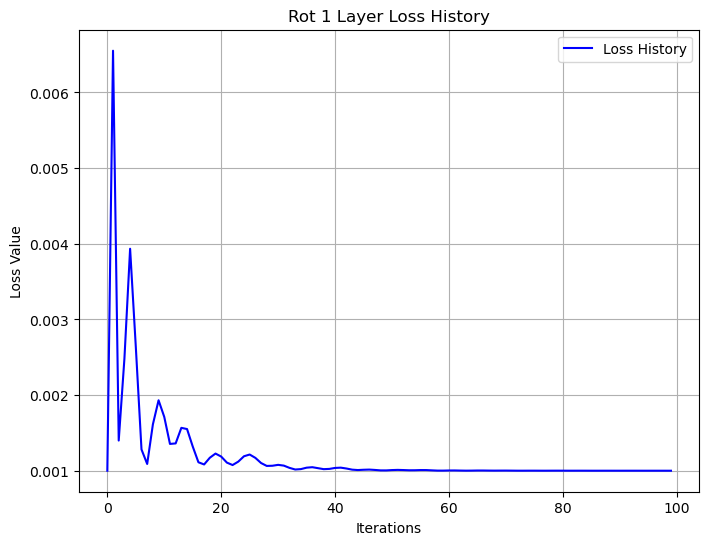

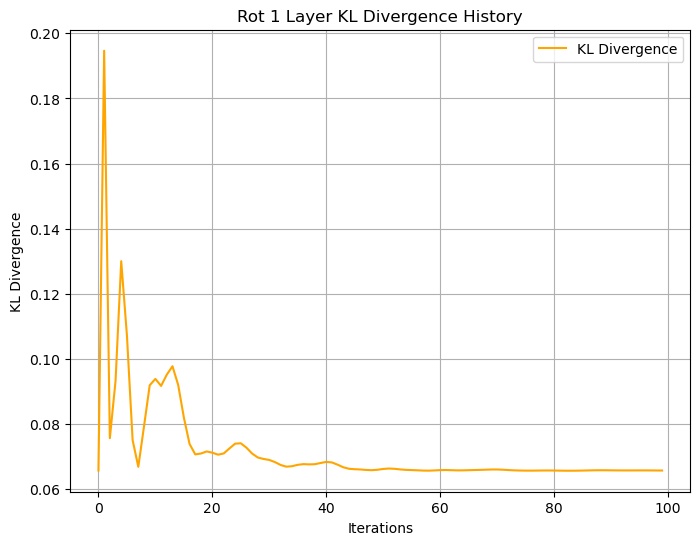

In [112]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(history, label="Loss History", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Rot 1 Layer Loss History")
plt.legend()
plt.grid(True)
plt.savefig("Results/Rot/Rot_1Layer_Loss_History.png")
plt.show()

# Plot the KL divergence history
plt.figure(figsize=(8, 6))
plt.plot(divs, label="KL Divergence", color='orange')
plt.xlabel("Iterations")
plt.ylabel("KL Divergence")
plt.title("Rot 1 Layer KL Divergence History")
plt.legend()
plt.grid(True)
plt.savefig("Results/Rot/Rot_1Layer_KL_Div_History.png")
plt.show()

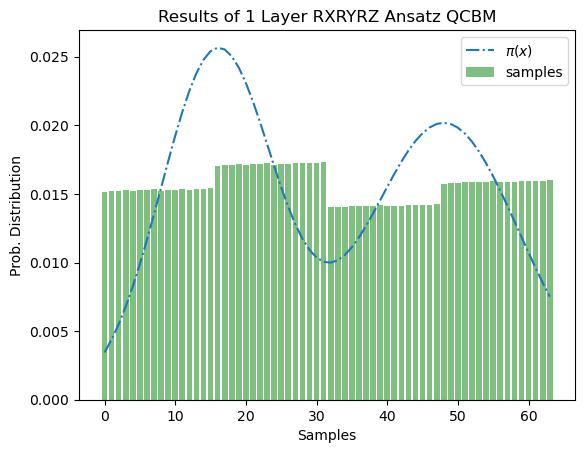

In [113]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.title('Results of 1 Layer RXRYRZ Ansatz QCBM')

plt.legend()

plt.savefig("Results/Rot/RXRYRZ_1Layers")
plt.show()

#### 2 Layers

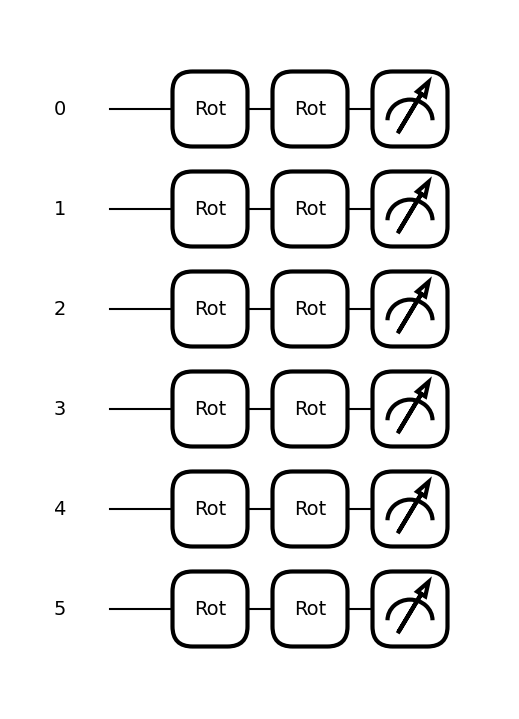

In [107]:
dev = qml.device("default.qubit", wires=n_qubits)
n_layers = 2

weights = []
for n in range(n_layers):
    weights.append(np.random.rand(n_qubits,3))

@qml.qnode(dev)
def circuit(weights):
    for n in range(n_layers):
        for i in range(n_qubits):
            qml.Rot(
                phi = weights[n][i][0], 
                theta = weights[n][i][1], 
                omega = weights[n][i][2], 
                wires = i, id=None
            )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.savefig("Ansatz/Rot/Rot_2Layer")
plt.show()

Step: 0 Loss: 0.0010 KL-div: 0.0657
Step: 10 Loss: 0.0012 KL-div: 0.0761
Step: 20 Loss: 0.0011 KL-div: 0.0688
Step: 30 Loss: 0.0010 KL-div: 0.0671
Step: 40 Loss: 0.0010 KL-div: 0.0659
Step: 50 Loss: 0.0010 KL-div: 0.0660
Step: 60 Loss: 0.0010 KL-div: 0.0657
Step: 70 Loss: 0.0010 KL-div: 0.0658
Step: 80 Loss: 0.0010 KL-div: 0.0658
Step: 90 Loss: 0.0010 KL-div: 0.0658


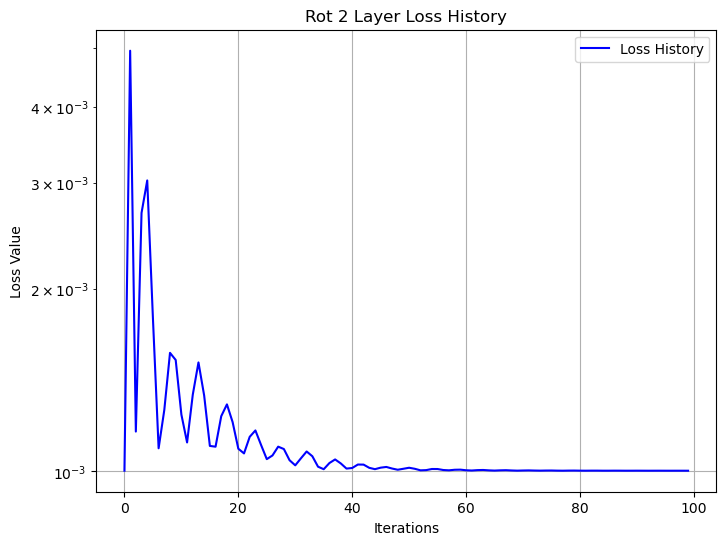

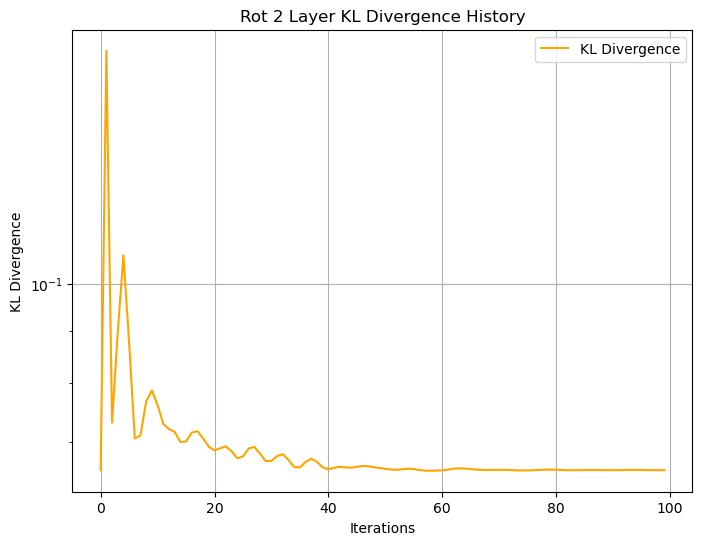

In [114]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
    updates, opt_state = opt.update(grads, opt_state)
    weights = optax.apply_updates(weights, updates)
    kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

# Plot the loss history
plt.figure(figsize=(8, 6))
plt.plot(history, label="Loss History", color='blue')
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Rot 2 Layer Loss History")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig("Results/Rot/Rot_2Layer_Loss_History_logscale.png")
plt.show()

# Plot the KL divergence history
plt.figure(figsize=(8, 6))
plt.plot(divs, label="KL Divergence", color='orange')
plt.xlabel("Iterations")
plt.ylabel("KL Divergence")
plt.title("Rot 2 Layer KL Divergence History")
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.savefig("Results/Rot/Rot_2Layer_KL_Div_History_logscale.png")
plt.show()

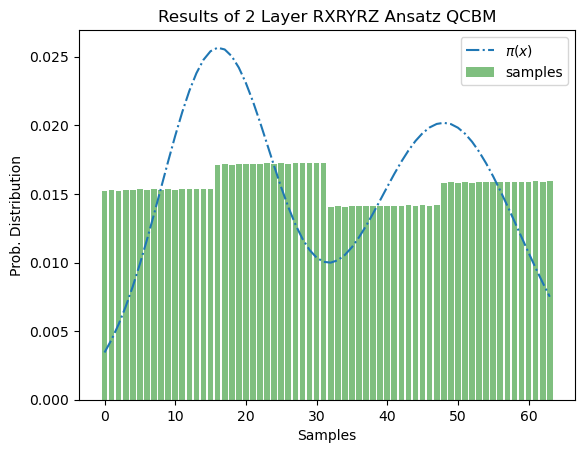

In [115]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.title('Results of 2 Layer RXRYRZ Ansatz QCBM')

plt.legend()

plt.savefig("Results/Rot/RXRYRZ_2Layers")
plt.show()

## Strongly Entagled Layers

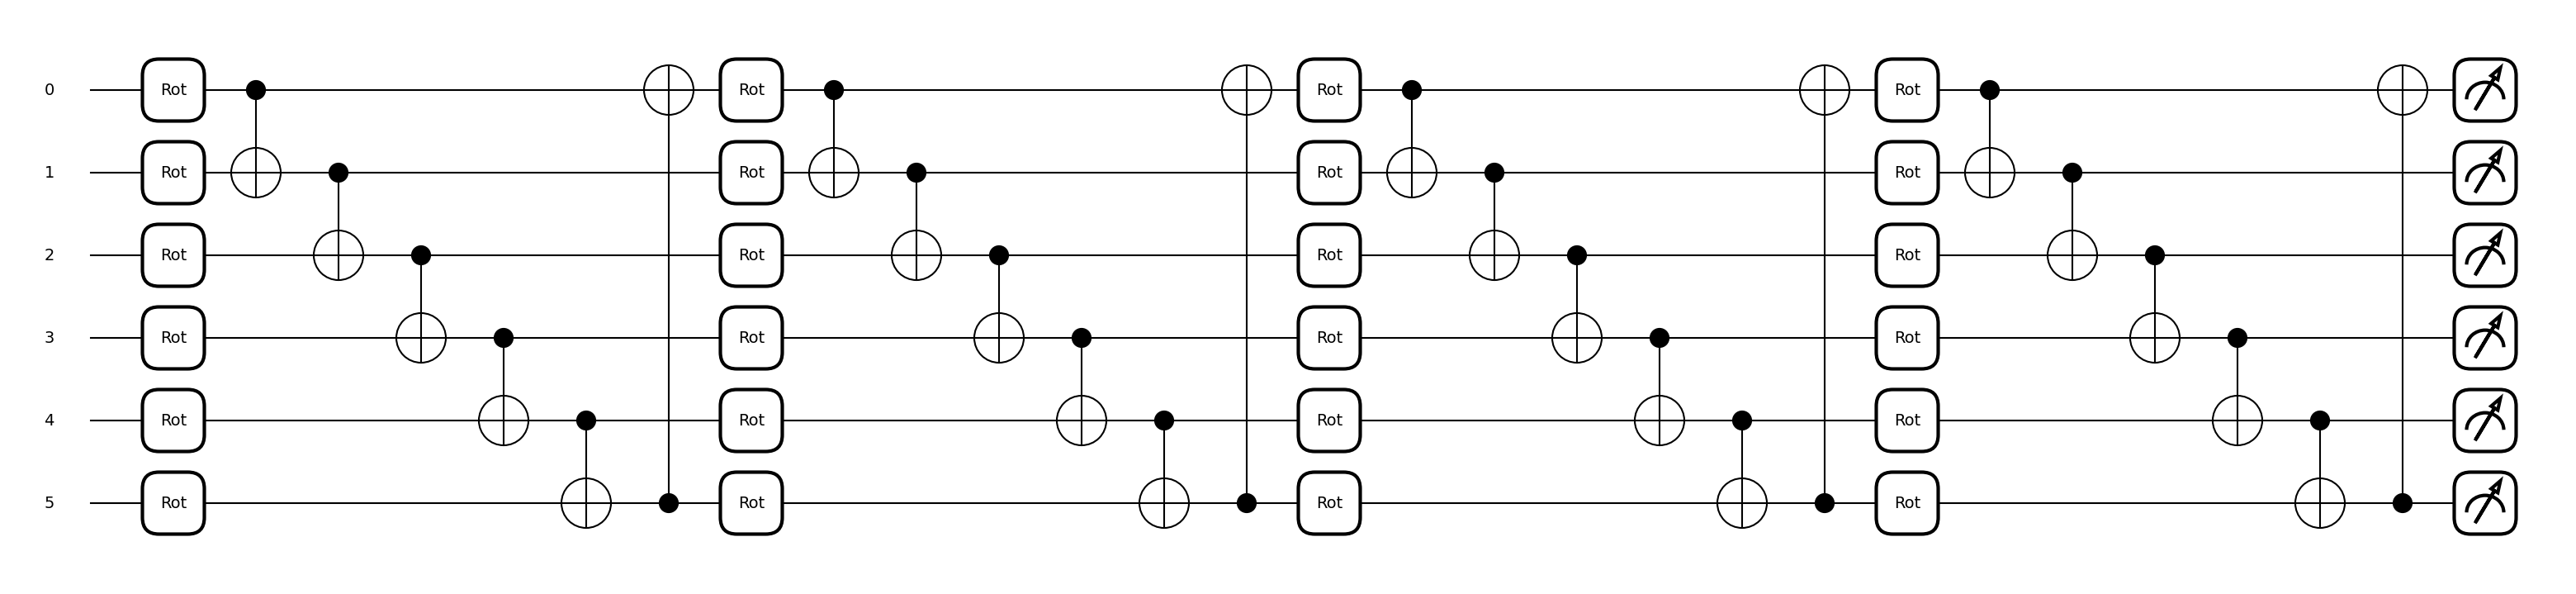

In [36]:
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 4

wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)

@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [ ]:
def QCBM_N_layers_run(n_layers = 4):
    dev = qml.device("default.qubit", wires=n_qubits)

    wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
    weights = np.random.random(size=wshape)

    @qml.qnode(dev)
    def circuit(weights):
        qml.StronglyEntanglingLayers(
            weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
        )
        return qml.probs()


    jit_circuit = jax.jit(circuit)

    qml.draw_mpl(circuit, level="device")(weights)
    plt.show()

    bandwidth = jnp.array([0.25, 60])
    space = jnp.arange(2**n_qubits)

    mmd = MMD(bandwidth, space)
    qcbm = QCBM(jit_circuit, mmd, data)

    opt = optax.adam(learning_rate=0.1)
    opt_state = opt.init(weights)

    history = []
    divs = []
    n_iterations = 200
    #n_iterations = int(200 / n_layers)


    for i in range(n_iterations):
        (loss_val, qcbm_probs), grads = jax.value_and_grad(qcbm.loss_fn, has_aux=True)(weights)
        updates, opt_state = opt.update(grads, opt_state)
        weights = optax.apply_updates(weights, updates)
        kl_div = -jnp.sum(qcbm.py * jnp.nan_to_num(jnp.log(qcbm_probs / qcbm.py)))
        # weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

        if i % 10 == 0:
            print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

        history.append(loss_val)
        divs.append(kl_div)

    
    qcbm_probs = qcbm.circ(weights)

    plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
    plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

    plt.xlabel("Samples")
    plt.ylabel("Prob. Distribution")

    plt.legend()
    plt.show()

    return history, divs

  0%|          | 0/10 [00:00<?, ?it/s]

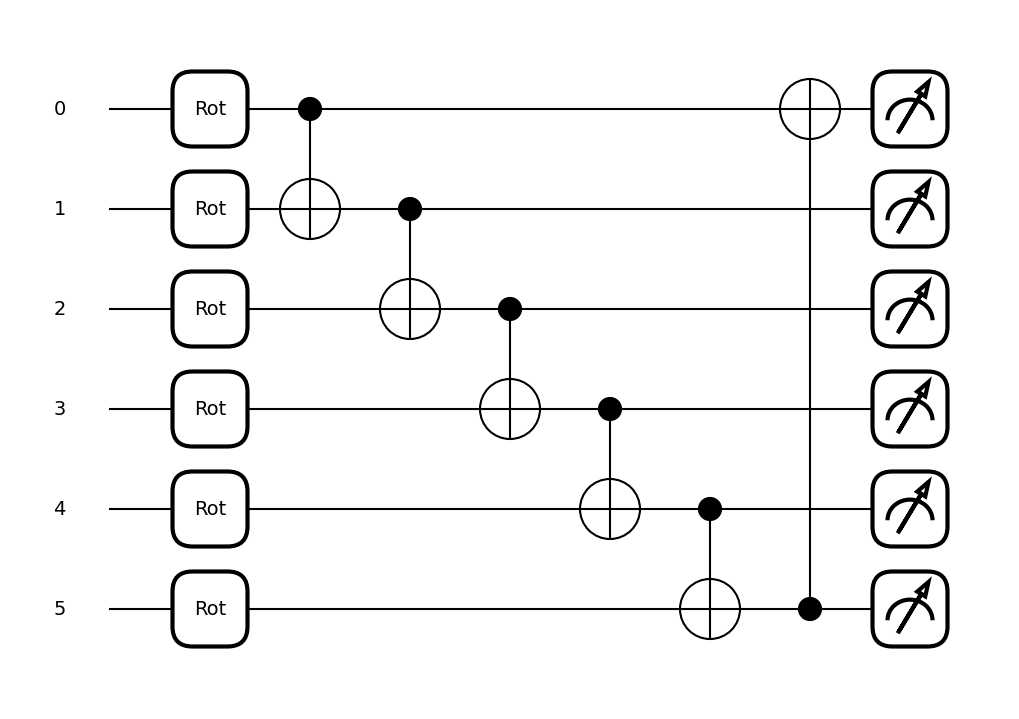

Step: 0 Loss: 0.2950 KL-div: 8.5171
Step: 1 Loss: 0.2291 KL-div: 6.3382
Step: 2 Loss: 0.1704 KL-div: 4.8964
Step: 3 Loss: 0.1228 KL-div: 3.8260
Step: 4 Loss: 0.0866 KL-div: 2.9955
Step: 5 Loss: 0.0605 KL-div: 2.3399
Step: 6 Loss: 0.0422 KL-div: 1.8197
Step: 7 Loss: 0.0296 KL-div: 1.4073
Step: 8 Loss: 0.0209 KL-div: 1.0818
Step: 9 Loss: 0.0149 KL-div: 0.8268
Step: 10 Loss: 0.0107 KL-div: 0.6290
Step: 11 Loss: 0.0078 KL-div: 0.4776
Step: 12 Loss: 0.0058 KL-div: 0.3638
Step: 13 Loss: 0.0043 KL-div: 0.2804
Step: 14 Loss: 0.0034 KL-div: 0.2216
Step: 15 Loss: 0.0028 KL-div: 0.1825
Step: 16 Loss: 0.0024 KL-div: 0.1591
Step: 17 Loss: 0.0023 KL-div: 0.1481
Step: 18 Loss: 0.0023 KL-div: 0.1467
Step: 19 Loss: 0.0024 KL-div: 0.1524
Step: 20 Loss: 0.0027 KL-div: 0.1632
Step: 21 Loss: 0.0031 KL-div: 0.1774
Step: 22 Loss: 0.0035 KL-div: 0.1933
Step: 23 Loss: 0.0039 KL-div: 0.2097
Step: 24 Loss: 0.0043 KL-div: 0.2255
Step: 25 Loss: 0.0047 KL-div: 0.2396
Step: 26 Loss: 0.0050 KL-div: 0.2514
Step: 27 Lo

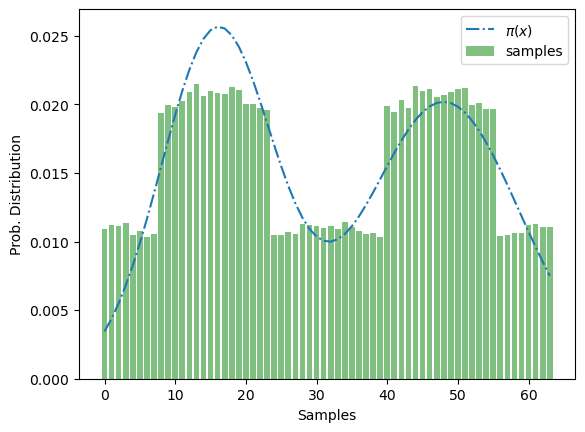

 10%|█         | 1/10 [00:03<00:27,  3.05s/it]

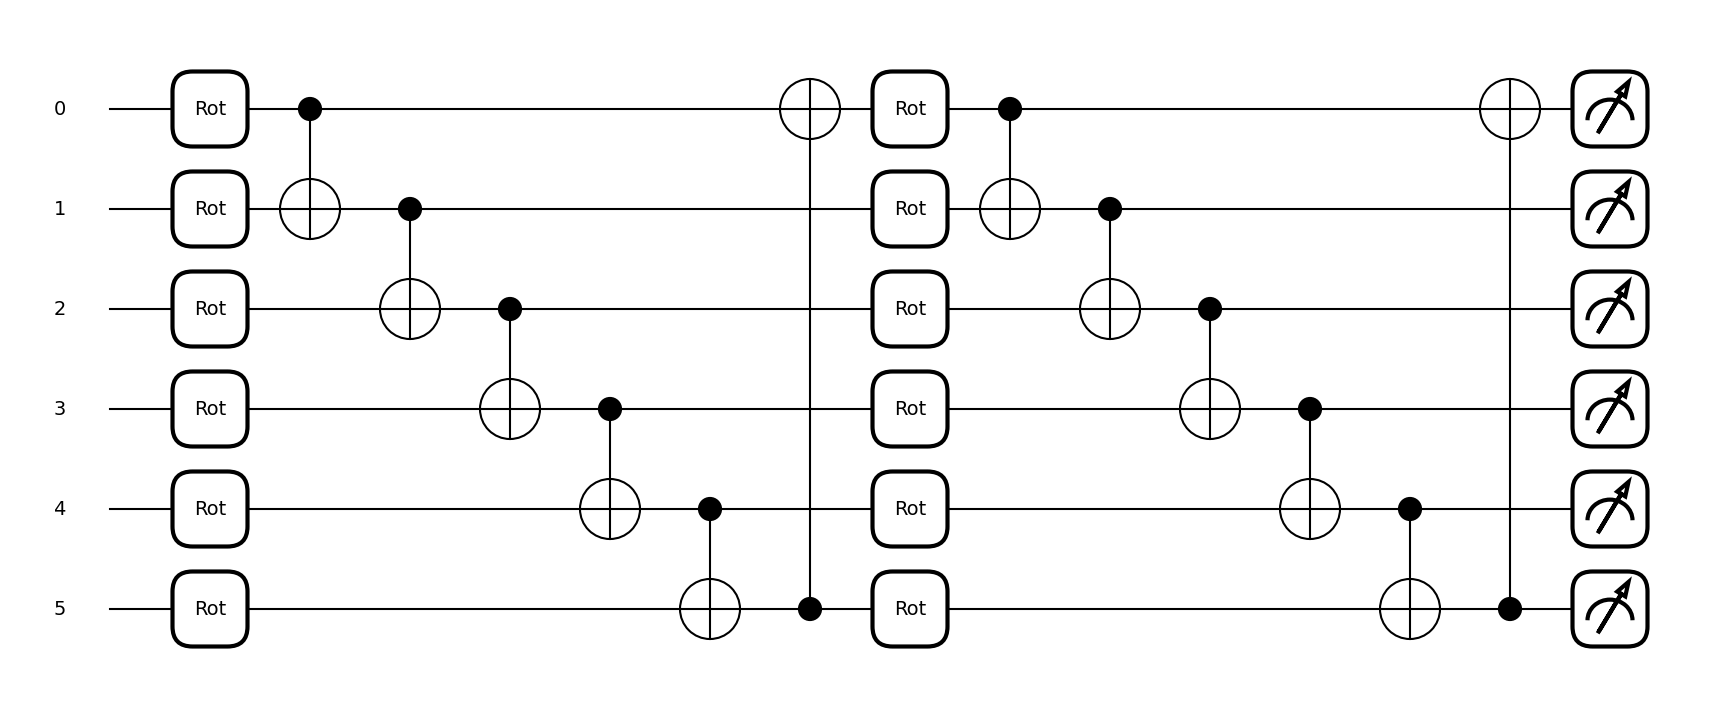

Step: 0 Loss: 0.0713 KL-div: 2.2153
Step: 1 Loss: 0.0383 KL-div: 1.5766
Step: 2 Loss: 0.0261 KL-div: 1.1332
Step: 3 Loss: 0.0204 KL-div: 0.8411
Step: 4 Loss: 0.0153 KL-div: 0.6614
Step: 5 Loss: 0.0113 KL-div: 0.5605
Step: 6 Loss: 0.0089 KL-div: 0.5006
Step: 7 Loss: 0.0076 KL-div: 0.4628
Step: 8 Loss: 0.0069 KL-div: 0.4938
Step: 9 Loss: 0.0069 KL-div: 0.5371
Step: 10 Loss: 0.0074 KL-div: 0.5524
Step: 11 Loss: 0.0082 KL-div: 0.5743
Step: 12 Loss: 0.0089 KL-div: 0.5947
Step: 13 Loss: 0.0091 KL-div: 0.6018
Step: 14 Loss: 0.0088 KL-div: 0.5921
Step: 15 Loss: 0.0081 KL-div: 0.5697
Step: 16 Loss: 0.0072 KL-div: 0.5411
Step: 17 Loss: 0.0062 KL-div: 0.5117
Step: 18 Loss: 0.0053 KL-div: 0.4847
Step: 19 Loss: 0.0045 KL-div: 0.4624
Step: 20 Loss: 0.0039 KL-div: 0.4482
Step: 21 Loss: 0.0035 KL-div: 0.4449
Step: 22 Loss: 0.0032 KL-div: 0.4412
Step: 23 Loss: 0.0031 KL-div: 0.4130
Step: 24 Loss: 0.0031 KL-div: 0.3789
Step: 25 Loss: 0.0031 KL-div: 0.3508
Step: 26 Loss: 0.0031 KL-div: 0.3299
Step: 27 Lo

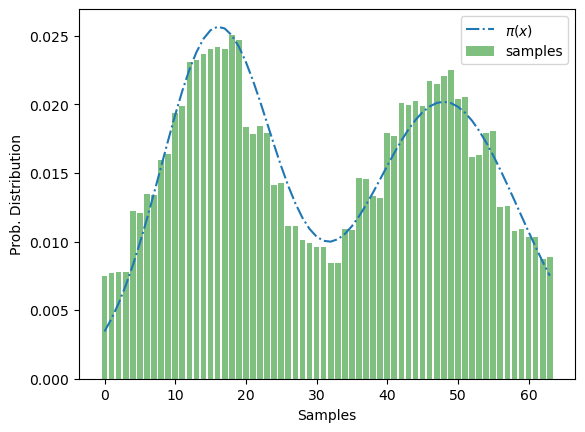

 20%|██        | 2/10 [00:06<00:25,  3.17s/it]

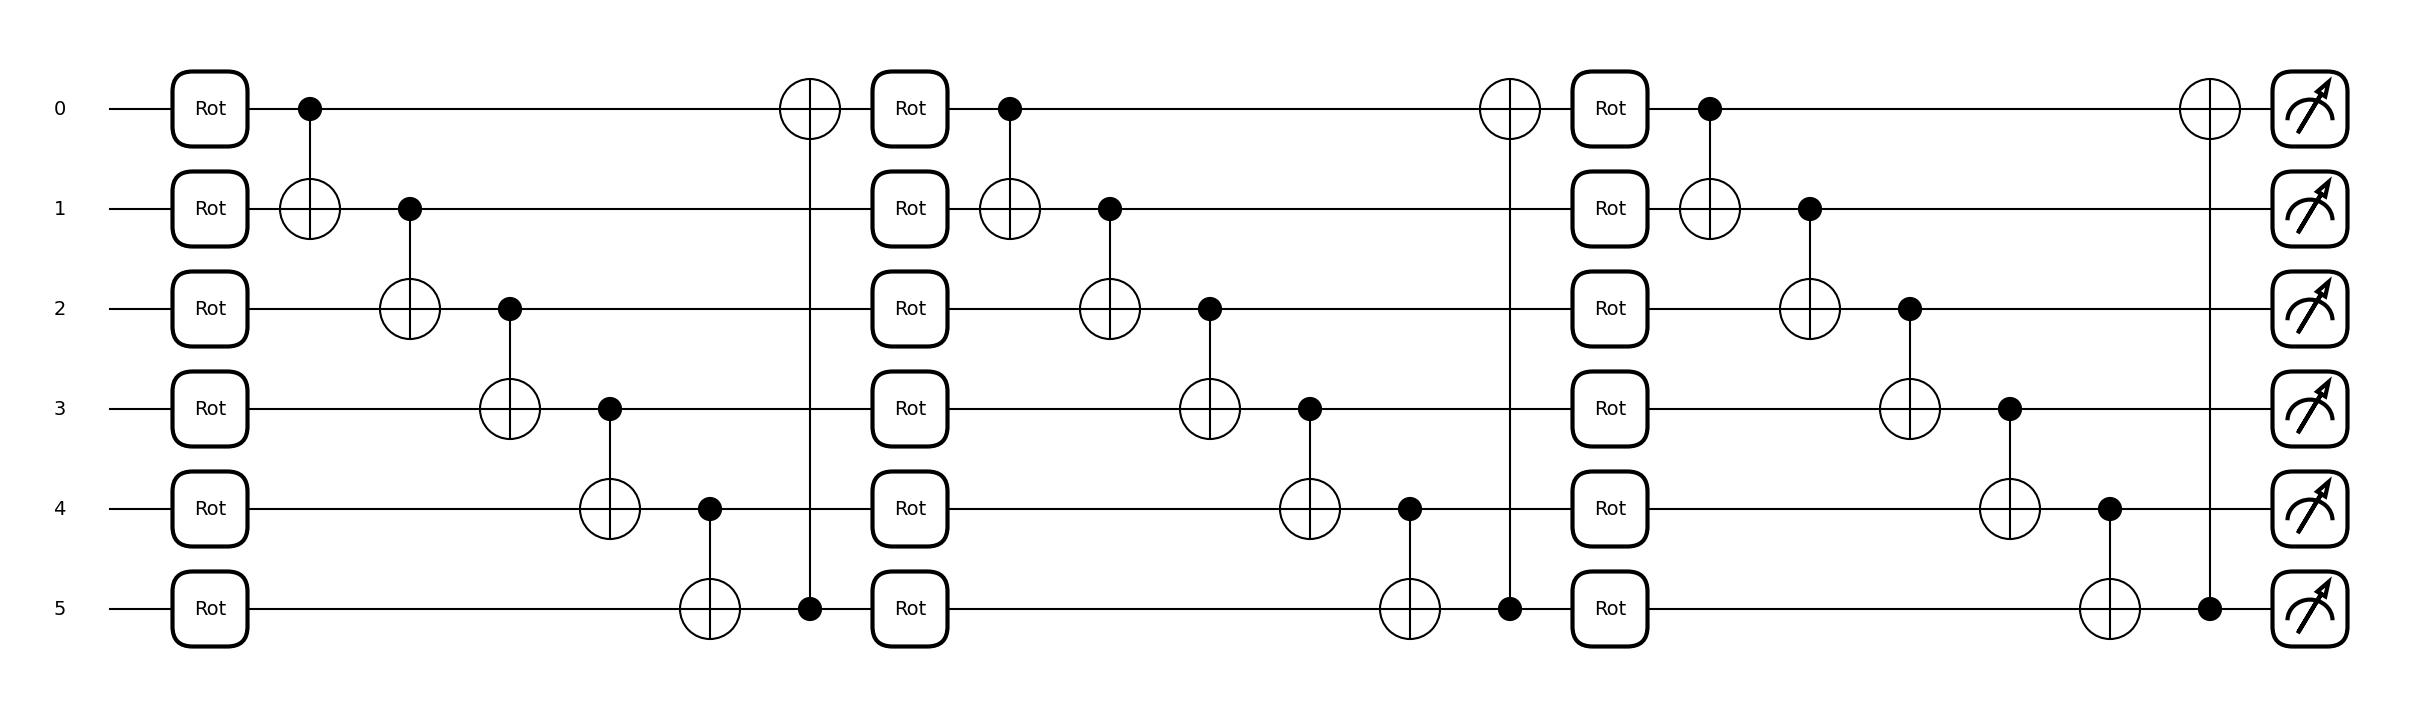

Step: 0 Loss: 0.0113 KL-div: 0.7631
Step: 1 Loss: 0.0065 KL-div: 0.5796
Step: 2 Loss: 0.0062 KL-div: 0.6356
Step: 3 Loss: 0.0057 KL-div: 0.6028
Step: 4 Loss: 0.0046 KL-div: 0.5463
Step: 5 Loss: 0.0040 KL-div: 0.5102
Step: 6 Loss: 0.0038 KL-div: 0.5049
Step: 7 Loss: 0.0036 KL-div: 0.4609
Step: 8 Loss: 0.0032 KL-div: 0.3270
Step: 9 Loss: 0.0027 KL-div: 0.2344
Step: 10 Loss: 0.0025 KL-div: 0.1919
Step: 11 Loss: 0.0022 KL-div: 0.1688
Step: 12 Loss: 0.0021 KL-div: 0.1519
Step: 13 Loss: 0.0019 KL-div: 0.1421
Step: 14 Loss: 0.0018 KL-div: 0.1377
Step: 15 Loss: 0.0017 KL-div: 0.1312
Step: 16 Loss: 0.0016 KL-div: 0.1216
Step: 17 Loss: 0.0016 KL-div: 0.1150
Step: 18 Loss: 0.0016 KL-div: 0.1146
Step: 19 Loss: 0.0016 KL-div: 0.1156
Step: 20 Loss: 0.0015 KL-div: 0.1110
Step: 21 Loss: 0.0014 KL-div: 0.1020
Step: 22 Loss: 0.0012 KL-div: 0.0937
Step: 23 Loss: 0.0012 KL-div: 0.0871
Step: 24 Loss: 0.0010 KL-div: 0.0800
Step: 25 Loss: 0.0009 KL-div: 0.0710
Step: 26 Loss: 0.0008 KL-div: 0.0608
Step: 27 Lo

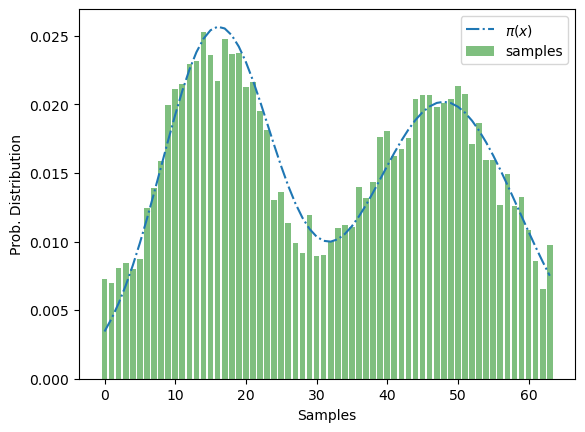

 30%|███       | 3/10 [00:10<00:25,  3.64s/it]

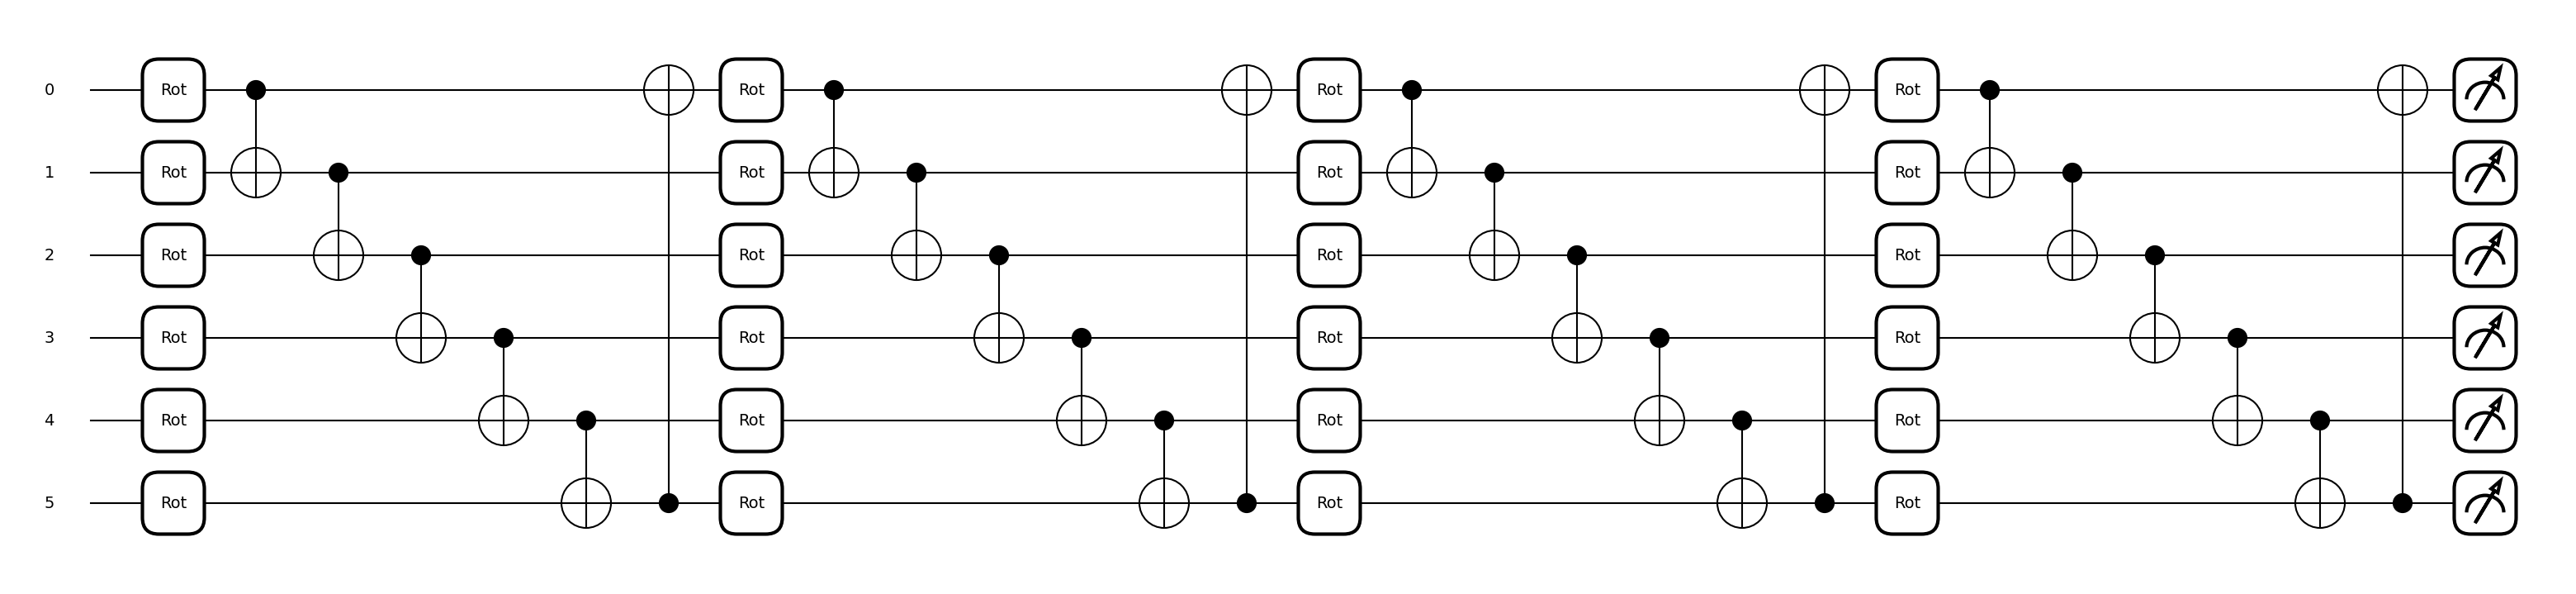

Step: 0 Loss: 0.0155 KL-div: 0.7531
Step: 1 Loss: 0.0076 KL-div: 0.5961
Step: 2 Loss: 0.0057 KL-div: 0.5598
Step: 3 Loss: 0.0055 KL-div: 0.5201
Step: 4 Loss: 0.0047 KL-div: 0.4045
Step: 5 Loss: 0.0037 KL-div: 0.3100
Step: 6 Loss: 0.0031 KL-div: 0.2776
Step: 7 Loss: 0.0028 KL-div: 0.2979
Step: 8 Loss: 0.0027 KL-div: 0.2929
Step: 9 Loss: 0.0023 KL-div: 0.2274
Step: 10 Loss: 0.0019 KL-div: 0.1633
Step: 11 Loss: 0.0015 KL-div: 0.1286
Step: 12 Loss: 0.0013 KL-div: 0.1190
Step: 13 Loss: 0.0014 KL-div: 0.1236
Step: 14 Loss: 0.0014 KL-div: 0.1264
Step: 15 Loss: 0.0014 KL-div: 0.1267
Step: 16 Loss: 0.0014 KL-div: 0.1267
Step: 17 Loss: 0.0013 KL-div: 0.1257
Step: 18 Loss: 0.0012 KL-div: 0.1207
Step: 19 Loss: 0.0011 KL-div: 0.1113
Step: 20 Loss: 0.0010 KL-div: 0.0993
Step: 21 Loss: 0.0009 KL-div: 0.0853
Step: 22 Loss: 0.0008 KL-div: 0.0702
Step: 23 Loss: 0.0006 KL-div: 0.0572
Step: 24 Loss: 0.0006 KL-div: 0.0493
Step: 25 Loss: 0.0005 KL-div: 0.0456
Step: 26 Loss: 0.0005 KL-div: 0.0430
Step: 27 Lo

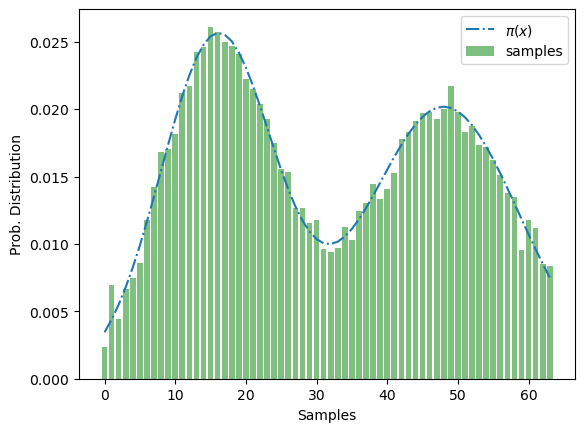

 40%|████      | 4/10 [00:15<00:26,  4.37s/it]

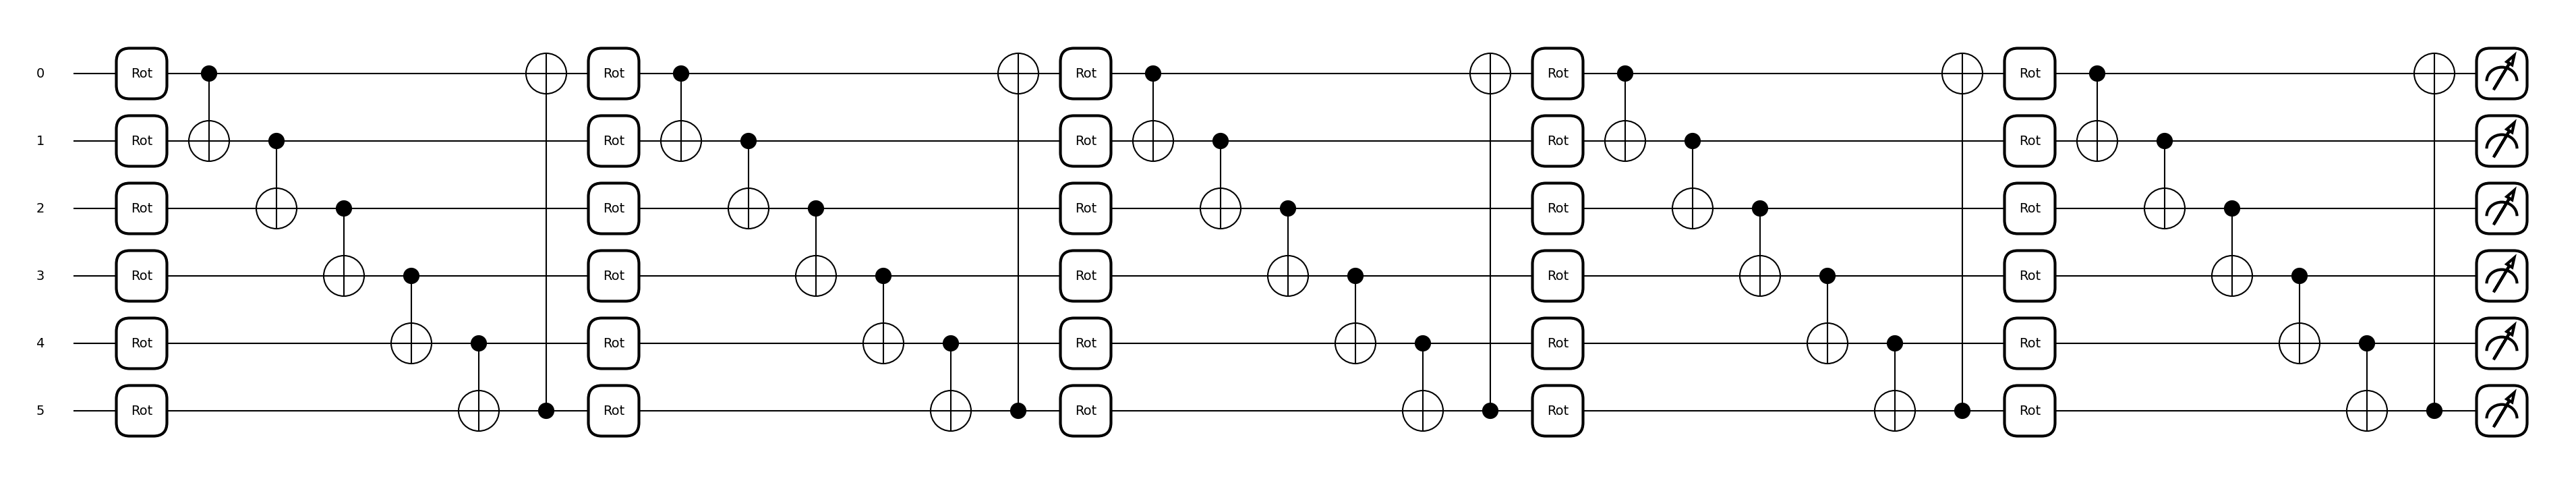

Step: 0 Loss: 0.0177 KL-div: 0.7582
Step: 1 Loss: 0.0059 KL-div: 0.3946
Step: 2 Loss: 0.0055 KL-div: 0.3932
Step: 3 Loss: 0.0057 KL-div: 0.3838
Step: 4 Loss: 0.0051 KL-div: 0.4712
Step: 5 Loss: 0.0043 KL-div: 0.4544
Step: 6 Loss: 0.0040 KL-div: 0.4300
Step: 7 Loss: 0.0036 KL-div: 0.3838
Step: 8 Loss: 0.0030 KL-div: 0.3015
Step: 9 Loss: 0.0024 KL-div: 0.2440
Step: 10 Loss: 0.0021 KL-div: 0.2392
Step: 11 Loss: 0.0019 KL-div: 0.2390
Step: 12 Loss: 0.0017 KL-div: 0.2382
Step: 13 Loss: 0.0017 KL-div: 0.2286
Step: 14 Loss: 0.0018 KL-div: 0.2364
Step: 15 Loss: 0.0018 KL-div: 0.2329
Step: 16 Loss: 0.0018 KL-div: 0.1971
Step: 17 Loss: 0.0016 KL-div: 0.1625
Step: 18 Loss: 0.0014 KL-div: 0.1362
Step: 19 Loss: 0.0013 KL-div: 0.1184
Step: 20 Loss: 0.0012 KL-div: 0.1052
Step: 21 Loss: 0.0011 KL-div: 0.0953
Step: 22 Loss: 0.0010 KL-div: 0.0876
Step: 23 Loss: 0.0009 KL-div: 0.0783
Step: 24 Loss: 0.0008 KL-div: 0.0679
Step: 25 Loss: 0.0008 KL-div: 0.0610
Step: 26 Loss: 0.0007 KL-div: 0.0579
Step: 27 Lo

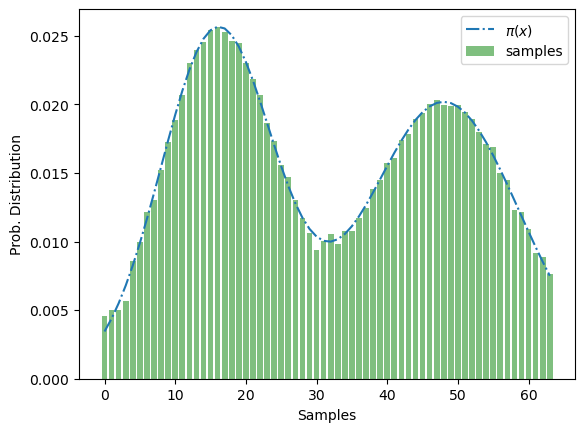

 50%|█████     | 5/10 [00:26<00:33,  6.64s/it]

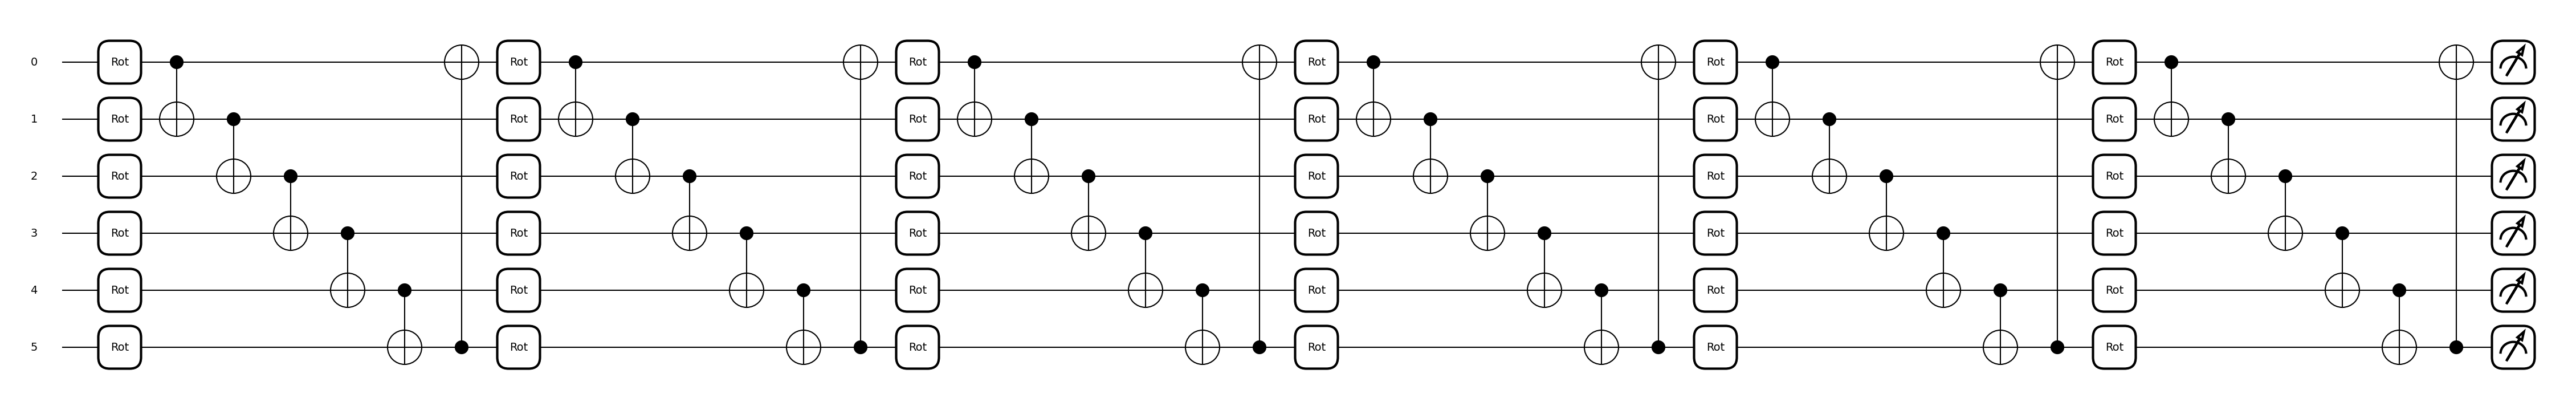

Step: 0 Loss: 0.0336 KL-div: 0.8730
Step: 1 Loss: 0.0107 KL-div: 0.6959
Step: 2 Loss: 0.0097 KL-div: 0.7546
Step: 3 Loss: 0.0073 KL-div: 0.6756
Step: 4 Loss: 0.0066 KL-div: 0.7854
Step: 5 Loss: 0.0057 KL-div: 0.5774
Step: 6 Loss: 0.0050 KL-div: 0.5027
Step: 7 Loss: 0.0048 KL-div: 0.4389
Step: 8 Loss: 0.0045 KL-div: 0.3919
Step: 9 Loss: 0.0037 KL-div: 0.3494
Step: 10 Loss: 0.0029 KL-div: 0.2761
Step: 11 Loss: 0.0029 KL-div: 0.2292
Step: 12 Loss: 0.0031 KL-div: 0.2174
Step: 13 Loss: 0.0031 KL-div: 0.2118
Step: 14 Loss: 0.0028 KL-div: 0.2003
Step: 15 Loss: 0.0024 KL-div: 0.1796
Step: 16 Loss: 0.0021 KL-div: 0.1513
Step: 17 Loss: 0.0017 KL-div: 0.1280
Step: 18 Loss: 0.0016 KL-div: 0.1180
Step: 19 Loss: 0.0015 KL-div: 0.1181
Step: 20 Loss: 0.0015 KL-div: 0.1225
Step: 21 Loss: 0.0013 KL-div: 0.1318
Step: 22 Loss: 0.0012 KL-div: 0.1464
Step: 23 Loss: 0.0011 KL-div: 0.1457
Step: 24 Loss: 0.0010 KL-div: 0.1148
Step: 25 Loss: 0.0009 KL-div: 0.0931
Step: 26 Loss: 0.0009 KL-div: 0.0797
Step: 27 Lo

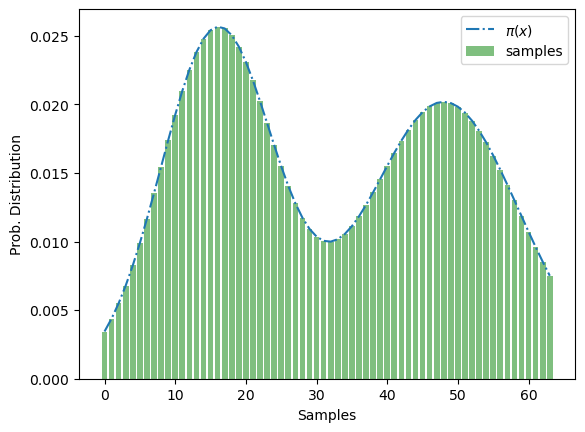

 60%|██████    | 6/10 [00:33<00:27,  6.82s/it]

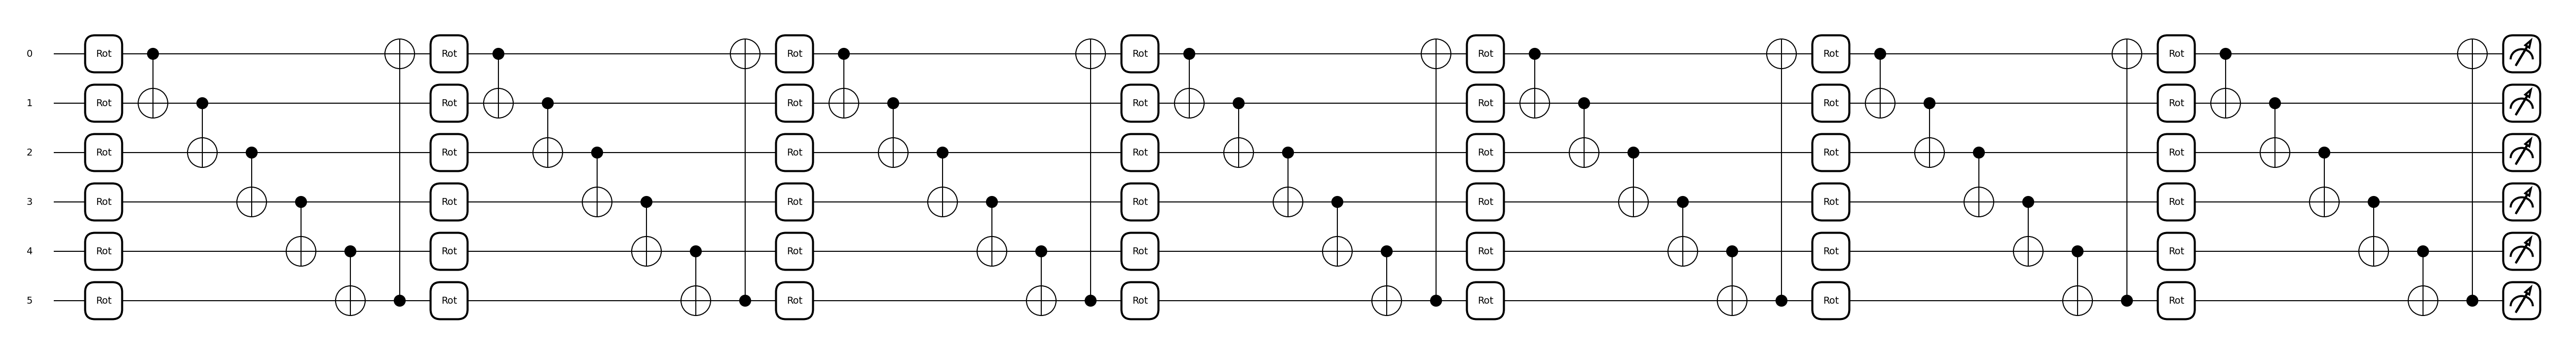

Step: 0 Loss: 0.0110 KL-div: 0.6450
Step: 1 Loss: 0.0081 KL-div: 0.7093
Step: 2 Loss: 0.0060 KL-div: 0.4543
Step: 3 Loss: 0.0042 KL-div: 0.3589
Step: 4 Loss: 0.0041 KL-div: 0.3821
Step: 5 Loss: 0.0033 KL-div: 0.3042
Step: 6 Loss: 0.0029 KL-div: 0.2513
Step: 7 Loss: 0.0028 KL-div: 0.2434
Step: 8 Loss: 0.0026 KL-div: 0.2376
Step: 9 Loss: 0.0021 KL-div: 0.2015
Step: 10 Loss: 0.0018 KL-div: 0.1429
Step: 11 Loss: 0.0014 KL-div: 0.0973
Step: 12 Loss: 0.0011 KL-div: 0.0776
Step: 13 Loss: 0.0011 KL-div: 0.0852
Step: 14 Loss: 0.0012 KL-div: 0.0953
Step: 15 Loss: 0.0011 KL-div: 0.0900
Step: 16 Loss: 0.0009 KL-div: 0.0787
Step: 17 Loss: 0.0008 KL-div: 0.0735
Step: 18 Loss: 0.0007 KL-div: 0.0640
Step: 19 Loss: 0.0006 KL-div: 0.0529
Step: 20 Loss: 0.0006 KL-div: 0.0479
Step: 21 Loss: 0.0006 KL-div: 0.0444
Step: 22 Loss: 0.0006 KL-div: 0.0404
Step: 23 Loss: 0.0005 KL-div: 0.0385
Step: 24 Loss: 0.0005 KL-div: 0.0375
Step: 25 Loss: 0.0004 KL-div: 0.0321
Step: 26 Loss: 0.0004 KL-div: 0.0259
Step: 27 Lo

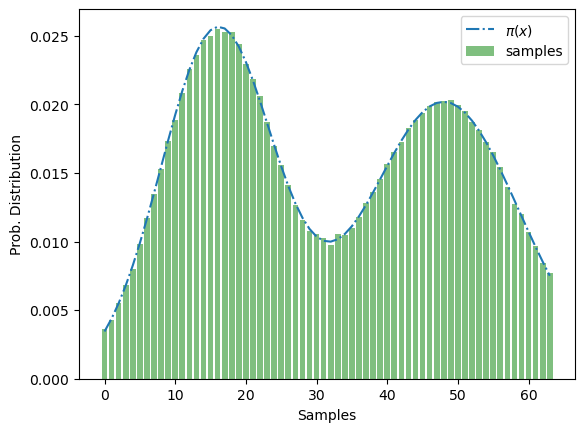

 70%|███████   | 7/10 [00:43<00:23,  7.84s/it]

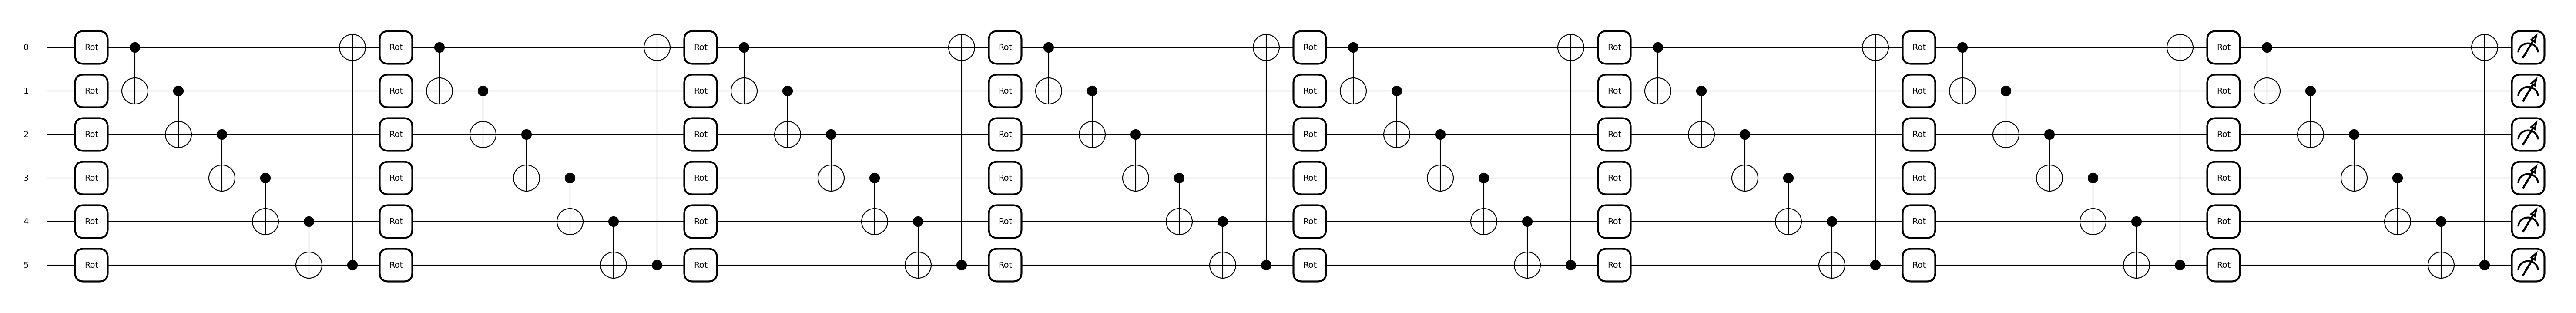

Step: 0 Loss: 0.0082 KL-div: 0.7137
Step: 1 Loss: 0.0080 KL-div: 0.4129
Step: 2 Loss: 0.0072 KL-div: 0.4862
Step: 3 Loss: 0.0043 KL-div: 0.4037
Step: 4 Loss: 0.0031 KL-div: 0.2917
Step: 5 Loss: 0.0029 KL-div: 0.2678
Step: 6 Loss: 0.0025 KL-div: 0.2425
Step: 7 Loss: 0.0022 KL-div: 0.2349
Step: 8 Loss: 0.0017 KL-div: 0.1414
Step: 9 Loss: 0.0016 KL-div: 0.1388
Step: 10 Loss: 0.0014 KL-div: 0.1171
Step: 11 Loss: 0.0012 KL-div: 0.0922
Step: 12 Loss: 0.0010 KL-div: 0.0743
Step: 13 Loss: 0.0008 KL-div: 0.0689
Step: 14 Loss: 0.0007 KL-div: 0.0764
Step: 15 Loss: 0.0007 KL-div: 0.0609
Step: 16 Loss: 0.0006 KL-div: 0.0476
Step: 17 Loss: 0.0005 KL-div: 0.0373
Step: 18 Loss: 0.0005 KL-div: 0.0363
Step: 19 Loss: 0.0005 KL-div: 0.0363
Step: 20 Loss: 0.0004 KL-div: 0.0342
Step: 21 Loss: 0.0004 KL-div: 0.0350
Step: 22 Loss: 0.0004 KL-div: 0.0355
Step: 23 Loss: 0.0003 KL-div: 0.0311
Step: 24 Loss: 0.0002 KL-div: 0.0266
Step: 25 Loss: 0.0002 KL-div: 0.0258
Step: 26 Loss: 0.0002 KL-div: 0.0251
Step: 27 Lo

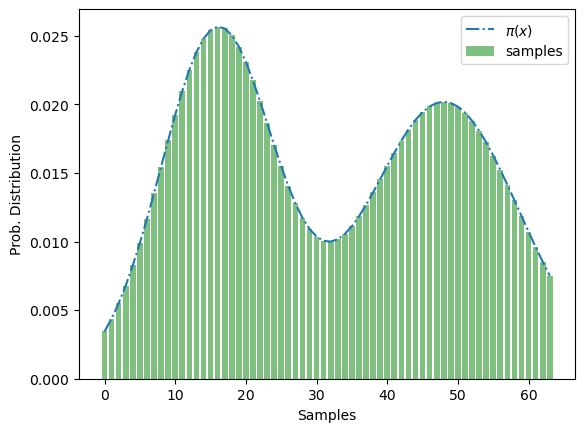

 80%|████████  | 8/10 [00:54<00:17,  8.72s/it]

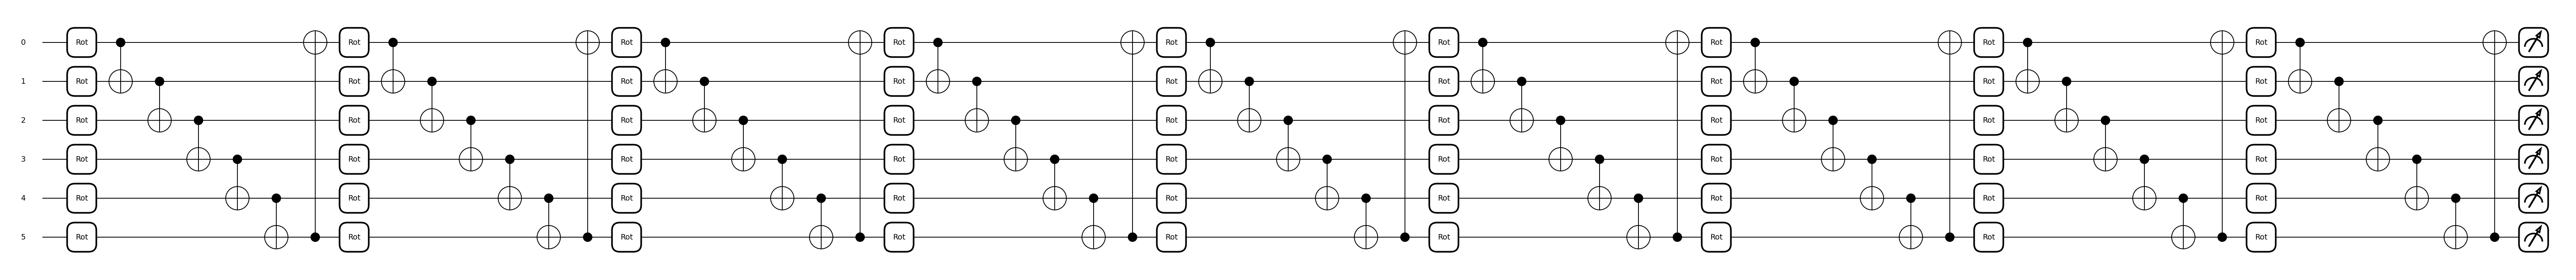

Step: 0 Loss: 0.0127 KL-div: 0.6077
Step: 1 Loss: 0.0091 KL-div: 0.4178
Step: 2 Loss: 0.0053 KL-div: 0.4266
Step: 3 Loss: 0.0050 KL-div: 0.4263
Step: 4 Loss: 0.0036 KL-div: 0.3965
Step: 5 Loss: 0.0032 KL-div: 0.3629
Step: 6 Loss: 0.0033 KL-div: 0.3246
Step: 7 Loss: 0.0030 KL-div: 0.3156
Step: 8 Loss: 0.0025 KL-div: 0.2415
Step: 9 Loss: 0.0022 KL-div: 0.1805
Step: 10 Loss: 0.0018 KL-div: 0.1489
Step: 11 Loss: 0.0014 KL-div: 0.1161
Step: 12 Loss: 0.0013 KL-div: 0.0962
Step: 13 Loss: 0.0010 KL-div: 0.0818
Step: 14 Loss: 0.0011 KL-div: 0.0775
Step: 15 Loss: 0.0012 KL-div: 0.0834
Step: 16 Loss: 0.0011 KL-div: 0.0839
Step: 17 Loss: 0.0011 KL-div: 0.0781
Step: 18 Loss: 0.0008 KL-div: 0.0660
Step: 19 Loss: 0.0007 KL-div: 0.0591
Step: 20 Loss: 0.0007 KL-div: 0.0567
Step: 21 Loss: 0.0006 KL-div: 0.0500
Step: 22 Loss: 0.0005 KL-div: 0.0353
Step: 23 Loss: 0.0004 KL-div: 0.0253
Step: 24 Loss: 0.0004 KL-div: 0.0265
Step: 25 Loss: 0.0004 KL-div: 0.0265
Step: 26 Loss: 0.0003 KL-div: 0.0230
Step: 27 Lo

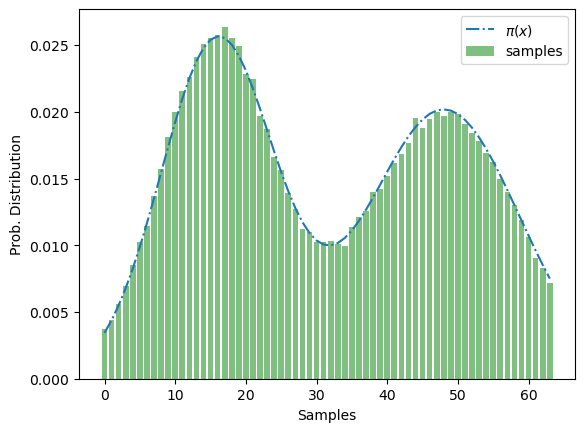

 90%|█████████ | 9/10 [01:07<00:10, 10.05s/it]

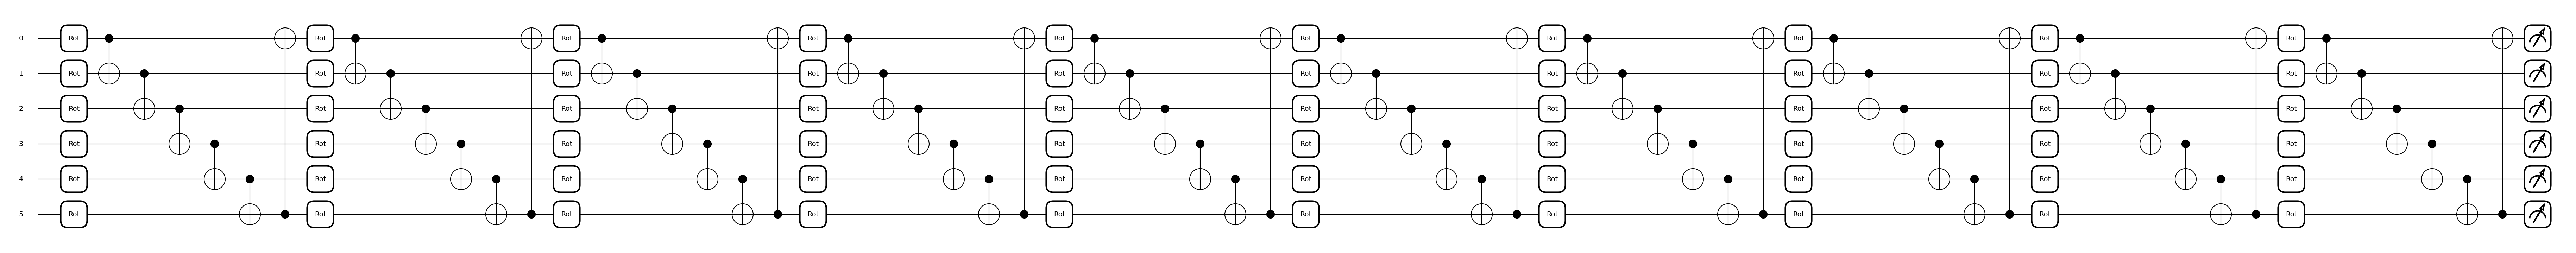

Step: 0 Loss: 0.0082 KL-div: 0.6336
Step: 1 Loss: 0.0111 KL-div: 0.5035
Step: 2 Loss: 0.0088 KL-div: 0.5628
Step: 3 Loss: 0.0083 KL-div: 0.4752
Step: 4 Loss: 0.0056 KL-div: 0.4621
Step: 5 Loss: 0.0060 KL-div: 0.5476
Step: 6 Loss: 0.0050 KL-div: 0.5215
Step: 7 Loss: 0.0041 KL-div: 0.3656
Step: 8 Loss: 0.0032 KL-div: 0.2459
Step: 9 Loss: 0.0024 KL-div: 0.1927
Step: 10 Loss: 0.0020 KL-div: 0.1614
Step: 11 Loss: 0.0018 KL-div: 0.1463
Step: 12 Loss: 0.0016 KL-div: 0.1539
Step: 13 Loss: 0.0015 KL-div: 0.1301
Step: 14 Loss: 0.0015 KL-div: 0.1241
Step: 15 Loss: 0.0014 KL-div: 0.1166
Step: 16 Loss: 0.0012 KL-div: 0.0961
Step: 17 Loss: 0.0009 KL-div: 0.0714
Step: 18 Loss: 0.0007 KL-div: 0.0599
Step: 19 Loss: 0.0008 KL-div: 0.0603
Step: 20 Loss: 0.0008 KL-div: 0.0547
Step: 21 Loss: 0.0006 KL-div: 0.0399
Step: 22 Loss: 0.0005 KL-div: 0.0305
Step: 23 Loss: 0.0005 KL-div: 0.0295
Step: 24 Loss: 0.0004 KL-div: 0.0308
Step: 25 Loss: 0.0004 KL-div: 0.0319
Step: 26 Loss: 0.0004 KL-div: 0.0306
Step: 27 Lo

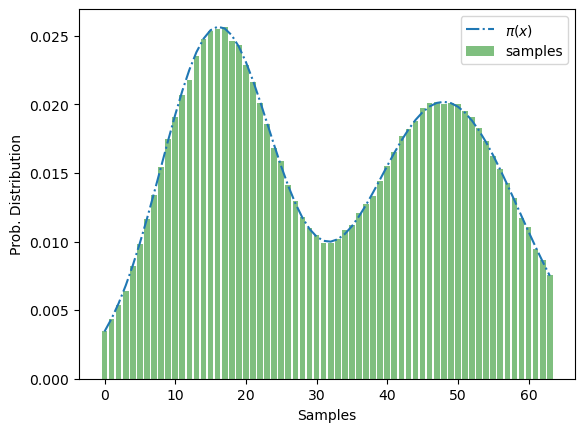

100%|██████████| 10/10 [01:22<00:00,  8.22s/it]


In [54]:
nLayers_test = [1,2,3,4,5,6,7,8,9,10]
hist_layers = []
divs_layers = []

for test in tqdm(nLayers_test):
    history, divs = QCBM_N_layers_run(n_layers = test)
    hist_layers.append(history)
    divs_layers.append(divs)

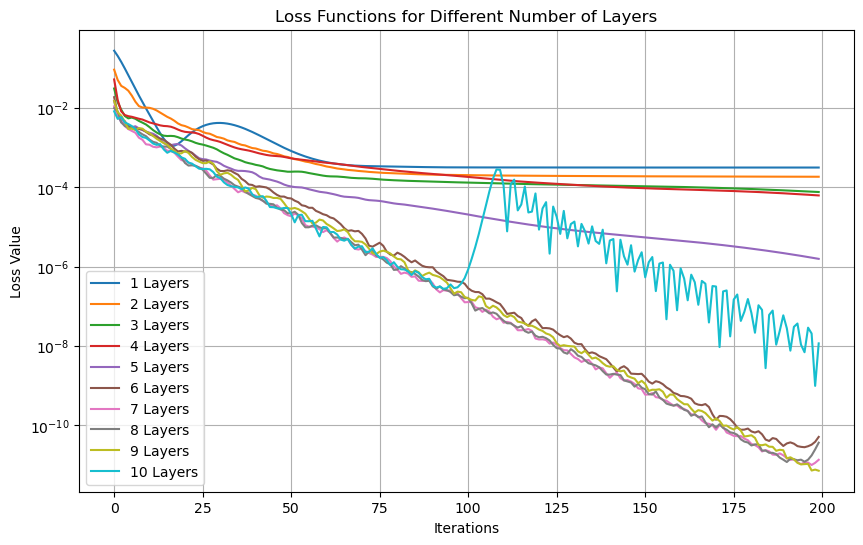

In [31]:
# Plot all loss histories from hist_layers
plt.figure(figsize=(10, 6))
for i, history in enumerate(hist_layers):
    plt.plot(range(len(history)), history, label=f"{nLayers_test[i]} Layers")

# Set logarithmic scale for y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Loss Value")
plt.title("Loss Functions for Different Number of Layers")
plt.legend()
plt.grid(True)
plt.show()

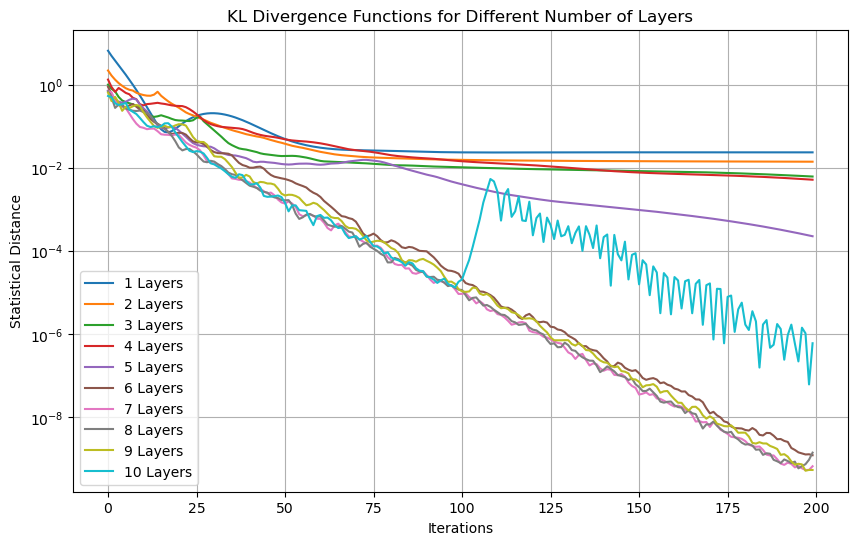

In [30]:
# Plot all loss histories from hist_layers
plt.figure(figsize=(10, 6))
for i, divs in enumerate(divs_layers):
    plt.plot(range(len(divs)), divs, label=f"{nLayers_test[i]} Layers")

# Set logarithmic scale for y-axis
plt.yscale('log')

# Add labels, title, and legend
plt.xlabel("Iterations")
plt.ylabel("Statistical Distance")
plt.title("KL Divergence Functions for Different Number of Layers")
plt.legend()
plt.grid(True)
plt.show()

# Testing different Ansatz

### Mathematical Respresentation of Ansatz

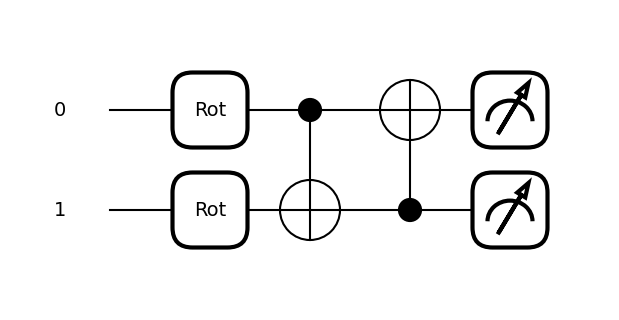

In [90]:
n_qubits = 2
dev = qml.device("default.qubit", wires=n_qubits)

n_layers = 1
wshape = qml.StronglyEntanglingLayers.shape(n_layers=n_layers, n_wires=n_qubits)
weights = np.random.random(size=wshape)

@qml.qnode(dev)
def circuit(weights):
    qml.StronglyEntanglingLayers(
        weights=weights, ranges=[1] * n_layers, wires=range(n_qubits)
    )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [212]:
from sympy import Matrix, symbols, cos, sin, exp, I

# Define the angle theta as a symbol
theta = symbols('theta')

# CNOT gate matrix (control qubit on the first, target qubit on the second)
CNOT = Matrix([
    [1, 0, 0, 0],
    [0, 1, 0, 0],
    [0, 0, 0, 1],
    [0, 0, 1, 0]
])

def I():
    return Matrix([
        [1,0],
        [0,1]
    ])

# Function to create RZ gate with a given angle name
def RZ(angle_name="theta"):
    angle = symbols(angle_name)  # Create a symbolic variable for the angle
    return Matrix([
        [exp(-I * angle / 2), 0],
        [0, exp(I * angle / 2)]
    ])

def RY(angle_name = "theta"):
    angle = symbols(angle_name)  # Create a symbolic variable for the angle
    return Matrix([
        [cos(angle / 2), - sin(angle / 2)],
        [sin(angle/ 2), cos(angle / 2)]
    ])

def RX(angle_name = "theta"):
    angle = symbols(angle_name)  # Create a symbolic variable for the angle
    return Matrix([
        [cos(angle / 2), sin(angle / 2)],
        [sin(angle/ 2), cos(angle / 2)]
    ])

In [194]:
from sympy import tensorproduct

def CNOT_gate(Control_U, Target_U):
    # CNOT gate matrix (control qubit on the first, target qubit on the second)
    CNOT = Matrix([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0]
    ])

    TargetControl_tensor = tensorproduct(Control_U, Target_U).as_mutable()
    TargetControl_Matrix = Matrix(4, 4, lambda i, j: TargetControl_tensor[i // 2][j // 2][i % 2][j % 2])
    return TargetControl_Matrix @ CNOT

In [195]:
CNOT_gate(RX(), RY())

Matrix([
[          cos(theta/2)**2, -sin(theta/2)*cos(theta/2),           -sin(theta/2)**2, sin(theta/2)*cos(theta/2)],
[sin(theta/2)*cos(theta/2),            cos(theta/2)**2,  sin(theta/2)*cos(theta/2),           sin(theta/2)**2],
[sin(theta/2)*cos(theta/2),           -sin(theta/2)**2, -sin(theta/2)*cos(theta/2),           cos(theta/2)**2],
[          sin(theta/2)**2,  sin(theta/2)*cos(theta/2),            cos(theta/2)**2, sin(theta/2)*cos(theta/2)]])

In [196]:
def Arbritray_Unitary(theta1 = "alpha", theta2 = "beta", theta3= "gamma"):
    return RZ(theta1) @ RY(theta2) @ RZ(theta3)

In [216]:
Arbritray_Unitary(theta1 = "alpha_0", theta2 = "beta_0", theta3= "gamma_0")

Matrix([
[exp(-I*alpha_0/2)*exp(-I*gamma_0/2)*cos(beta_0/2), -exp(-I*alpha_0/2)*exp(I*gamma_0/2)*sin(beta_0/2)],
[ exp(I*alpha_0/2)*exp(-I*gamma_0/2)*sin(beta_0/2),   exp(I*alpha_0/2)*exp(I*gamma_0/2)*cos(beta_0/2)]])

In [226]:
from sympy import tensorproduct

AU0 = Arbritray_Unitary(theta1 = "alpha_0", theta2 = "beta_0", theta3= "gamma_0")
AU1 = Arbritray_Unitary(theta1 = "alpha_1", theta2 = "beta_1", theta3= "gamma_1")

AU0_AU1_tensor = tensorproduct(AU0, AU1)
AU0_AU1 = Matrix(4, 4, lambda i, j: AU0_AU1_tensor[i // 2][j // 2][i % 2][j % 2])

AU1_AU0_tensor = tensorproduct(AU1, AU0)
AU1_AU0 = Matrix(4, 4, lambda i, j: AU1_AU0_tensor[i // 2][j // 2][i % 2][j % 2])

In [224]:
AU0_AU1 @ CNOT_gate(AU0,AU1) @ CNOT_gate(AU1, AU0)

Matrix([
[(sin(beta_0/2)**2*sin(beta_1/2)**2 - exp(-I*alpha_1)*exp(-I*gamma_1)*sin(beta_0/2)**2*cos(beta_1/2)**2 - exp(-I*alpha_0)*exp(-I*gamma_0)*sin(beta_1/2)**2*cos(beta_0/2)**2 + exp(-I*alpha_0)*exp(-I*alpha_1)*exp(-I*gamma_0)*exp(-I*gamma_1)*cos(beta_0/2)**2*cos(beta_1/2)**2)*exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2) + (exp(I*gamma_0)*sin(beta_0/2)*sin(beta_1/2)**2*cos(beta_0/2) - exp(-I*alpha_1)*exp(I*gamma_0)*exp(-I*gamma_1)*sin(beta_0/2)*cos(beta_0/2)*cos(beta_1/2)**2 + exp(-I*alpha_0)*sin(beta_0/2)*sin(beta_1/2)**2*cos(beta_0/2) - exp(-I*alpha_0)*exp(-I*alpha_1)*exp(-I*gamma_1)*sin(beta_0/2)*cos(beta_0/2)*cos(beta_1/2)**2)*exp(I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2) + (exp(I*gamma_1)*sin(beta_0/2)**2*sin(beta_1/2)*cos(beta_1/2) + exp(-I*alpha_1)*sin(beta_0/2)**2*sin(beta_1/2)*cos(beta_1/2) - exp(-I*alpha_0)*exp(-I*gamma_0)*exp(I*gamma_1)*sin(beta_1/2)*cos(beta_0/2)**

In [225]:
AU0_AU1

Matrix([
[exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2), exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2)],
[ exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2),   exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2),  -exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2), -exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2)],
[ exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2),  -exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_

In [227]:
AU1_AU0

Matrix([
[exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2), -exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2), exp(-I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2)],
[ exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_0/2)*cos(beta_1/2),   exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*cos(beta_0/2)*cos(beta_1/2),  -exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(-I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_0/2)*sin(beta_1/2), -exp(I*alpha_0/2)*exp(-I*alpha_1/2)*exp(I*gamma_0/2)*exp(I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2)],
[ exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(-I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_1/2)*cos(beta_0/2),  -exp(-I*alpha_0/2)*exp(I*alpha_1/2)*exp(I*gamma_0/2)*exp(-I*gamma_1/2)*sin(beta_

## Add Hadamards to intial state in ansatz 
#### |+> intial state versus |0> state

## Single Rotation Ansatz

### Arbritrary Unitary Rotations - Classically Simulatable

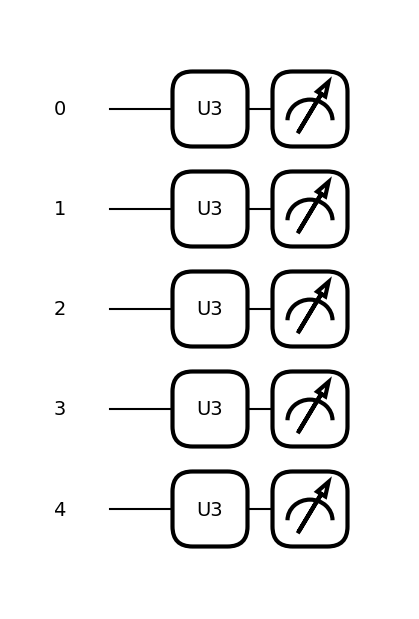

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)

weights = np.random.rand(n_qubits,3)


@qml.qnode(dev)
def circuit(weights):
    for i in range(n_qubits):
        qml.U3(
            theta = weights[i][0], 
            phi = weights[i][1], 
            delta = weights[i][2], 
            wires = i, id=None
        )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [ ]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 100

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.1920 KL-div: 2.9348
Step: 10 Loss: 0.0057 KL-div: 0.1980
Step: 20 Loss: 0.0136 KL-div: 0.2938
Step: 30 Loss: 0.0051 KL-div: 0.1612
Step: 40 Loss: 0.0041 KL-div: 0.1373
Step: 50 Loss: 0.0037 KL-div: 0.1309
Step: 60 Loss: 0.0034 KL-div: 0.1249
Step: 70 Loss: 0.0033 KL-div: 0.1245
Step: 80 Loss: 0.0033 KL-div: 0.1243
Step: 90 Loss: 0.0033 KL-div: 0.1237


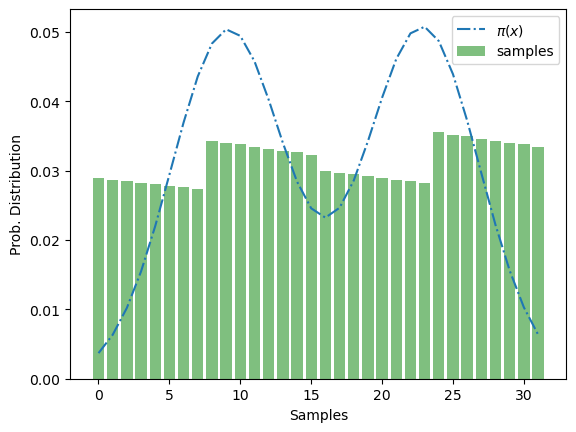

In [ ]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()

## RX, RY, RZ Rotations

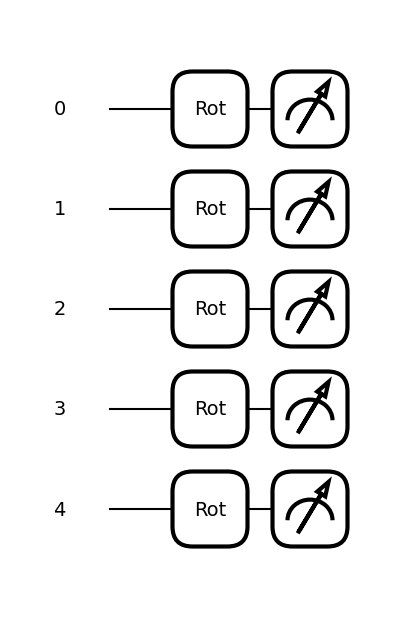

In [ ]:
dev = qml.device("default.qubit", wires=n_qubits)

weights = np.random.rand(n_qubits,3)


@qml.qnode(dev)
def circuit(weights):
    for i in range(n_qubits):
        qml.Rot(
            phi = weights[i][0], 
            theta = weights[i][1], 
            omega = weights[i][2], 
            wires = i, id=None
        )
    return qml.probs()


jit_circuit = jax.jit(circuit)

qml.draw_mpl(circuit, level="device")(weights)
plt.show()

In [ ]:
bandwidth = jnp.array([0.25, 60])
space = jnp.arange(2**n_qubits)

mmd = MMD(bandwidth, space)
qcbm = QCBM(jit_circuit, mmd, data)

opt = optax.adam(learning_rate=0.1)

opt_state = opt.init(weights)

history = []
divs = []
n_iterations = 200

for i in range(n_iterations):
    weights, opt_state, loss_val, kl_div = update_step(weights, opt_state)

    if i % 10 == 0:
        print(f"Step: {i} Loss: {loss_val:.4f} KL-div: {kl_div:.4f}")

    history.append(loss_val)
    divs.append(kl_div)

Step: 0 Loss: 0.0033 KL-div: 0.1234
Step: 10 Loss: 0.0035 KL-div: 0.1276
Step: 20 Loss: 0.0034 KL-div: 0.1262
Step: 30 Loss: 0.0033 KL-div: 0.1247
Step: 40 Loss: 0.0033 KL-div: 0.1240
Step: 50 Loss: 0.0033 KL-div: 0.1237
Step: 60 Loss: 0.0033 KL-div: 0.1236
Step: 70 Loss: 0.0033 KL-div: 0.1235
Step: 80 Loss: 0.0033 KL-div: 0.1234
Step: 90 Loss: 0.0033 KL-div: 0.1234
Step: 100 Loss: 0.0033 KL-div: 0.1234
Step: 110 Loss: 0.0033 KL-div: 0.1234
Step: 120 Loss: 0.0033 KL-div: 0.1234
Step: 130 Loss: 0.0033 KL-div: 0.1234
Step: 140 Loss: 0.0033 KL-div: 0.1234
Step: 150 Loss: 0.0033 KL-div: 0.1234
Step: 160 Loss: 0.0033 KL-div: 0.1234
Step: 170 Loss: 0.0033 KL-div: 0.1234
Step: 180 Loss: 0.0033 KL-div: 0.1234
Step: 190 Loss: 0.0033 KL-div: 0.1234


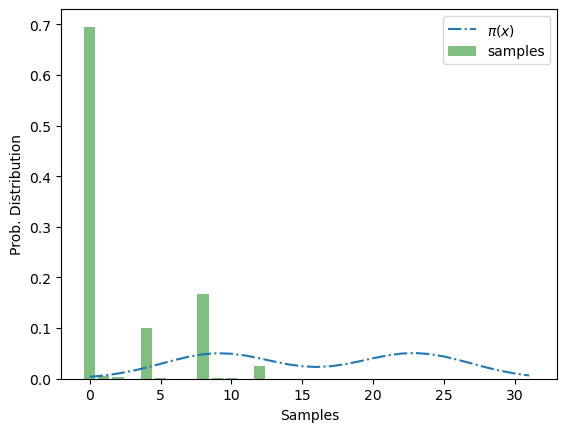

In [ ]:
qcbm_probs = qcbm.circ(weights)

plt.plot(range(x_max), data, linestyle="-.", label=r"$\pi(x)$")
plt.bar(range(x_max), qcbm_probs, color="green", alpha=0.5, label="samples")

plt.xlabel("Samples")
plt.ylabel("Prob. Distribution")

plt.legend()
plt.show()

## Vary Initial Conditions